## Fat CNN model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gym
%matplotlib inline

In [2]:
# These functions allow us to preprocess 
# original images from size of 210x160x3 
# to size of 110x84 (grayscale images).

import cv2

def preprocess(image):
    def_h = 84
    def_w = 84
    img = 0.299*image[:,:,0] + 0.587*image[:,:,1] + 0.114*image[:,:,2]
    img = cv2.resize(img, (def_h, def_w))
    img = np.expand_dims(img, axis=2)
    return img

def preprocess_tensor(tensor):
    def_h = 84
    def_w = 84
    tnsr = np.zeros((tensor.shape[0], tensor.shape[1], def_w, def_h, 1))
    for i in xrange(tensor.shape[0]):
        for j in xrange(tensor.shape[1]):
            img = 0.299*tensor[i,j,:,:,0] + 0.587*tensor[i,j,:,:,1] + 0.114*tensor[i,j,:,:,2]
            tnsr[i,j,:,:,0] = cv2.resize(img, (def_h, def_w))
    return tnsr

def preprocess_tensor4(tensor):
    def_h = 84
    def_w = 84
    tnsr = np.zeros((tensor.shape[0], def_w, def_h, 1))
    for i in xrange(tensor.shape[0]):
        img = 0.299*tensor[i,:,:,0] + 0.587*tensor[i,:,:,1] + 0.114*tensor[i,:,:,2]
        tnsr[i,:,:,0] = cv2.resize(img, (def_h, def_w))
    return tnsr

### Game Parameters

In [8]:
experiment_setup_name = "tutorial.gym.atari.MsPacman-v0.cnn"
GAME_TITLE = 'MsPacman-v0'
N_PARALLEL_GAMES = 20
replay_seq_len = 50

atari = gym.make(GAME_TITLE)
atari.reset()
n_actions = atari.action_space.n
observation_shape = (None,) + (84, 84, 1)
action_names = ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']
print action_names

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


In [9]:
observation_shape

(None, 84, 84, 1)

In [10]:
del atari

### Observations

In [11]:
import lasagne
from lasagne.layers import InputLayer, DimshuffleLayer

observation_layer = InputLayer(observation_shape, name="images input")
observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))

### Memory Layer

In [13]:
from agentnet.memory import WindowAugmentation
window_size = 4

prev_window = InputLayer((None,window_size)+tuple(observation_reshape.output_shape[1:]),
                        name = "previous window state")

window = WindowAugmentation(observation_reshape,
                            prev_window,
                            name = "new window state")

memory_dict = {window:prev_window}

### Policy

In [16]:
from lasagne.layers import ExpressionLayer, DenseLayer

window_max = ExpressionLayer(window,
                             lambda a: a.max(axis=1),
                             output_shape = (None,)+window.output_shape[2:])

nn = lasagne.layers.Conv2DLayer(window_max, num_filters=16, filter_size=(8, 8), stride=(2, 2))
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.Conv2DLayer(nn, num_filters=32, filter_size=(4, 4), stride=(2, 2))
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.Conv2DLayer(nn, num_filters=64, filter_size=(4, 4), stride=(2, 2))
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.Conv2DLayer(nn, num_filters=64, filter_size=(4, 4), stride=(2, 2))
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.DenseLayer(nn, num_units=256, nonlinearity=lasagne.nonlinearities.leaky_rectify)
nn = lasagne.layers.BatchNormLayer(nn)

### Resolver

In [17]:
from agentnet.resolver import EpsilonGreedyResolver

q_eval = DenseLayer(nn,
                   num_units = n_actions,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="QEvaluator")
resolver = EpsilonGreedyResolver(q_eval,name="resolver")

### Putting it together

In [19]:
from agentnet.agent import Agent
agent = Agent(observation_layer,
              memory_dict,
              q_eval,resolver)


weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 QEvaluator.W,
 QEvaluator.b]

### step function

In [20]:
applier_fun = agent.get_react_function()

def step(observation, prev_memories = 'zeros', batch_size = N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""

    if prev_memories == 'zeros':
        prev_memories = agent.get_zeros_like_memory(batch_size=batch_size)
    
    obs = preprocess_tensor4(np.array(observation))
    if len(np.array(prev_memories).shape) == 5:
        res = applier_fun(obs, *[prev_memories])
    else:
        res = applier_fun(obs, *prev_memories)
    
    action = res[0]
    memories = res[1:]
    return action, memories[0]

### Environment, pool and all other stuff

In [21]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent, n_games=N_PARALLEL_GAMES, make_env=GAME_TITLE, agent_step=step)

[2017-05-23 04:00:41,095] Making new env: MsPacman-v0
[2017-05-23 04:00:41,357] Making new env: MsPacman-v0
[2017-05-23 04:00:41,533] Making new env: MsPacman-v0
[2017-05-23 04:00:41,710] Making new env: MsPacman-v0
[2017-05-23 04:00:41,886] Making new env: MsPacman-v0
[2017-05-23 04:00:42,062] Making new env: MsPacman-v0
[2017-05-23 04:00:42,236] Making new env: MsPacman-v0
[2017-05-23 04:00:42,407] Making new env: MsPacman-v0


In [22]:
%%time
observation_log,action_log,reward_log,_,_,_  = pool.interact(50)

print(np.array(action_names)[np.array(action_log)[:3,:5]])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


[['NOOP' 'UPLEFT' 'UPLEFT' 'LEFT' 'UP']
 ['NOOP' 'DOWN' 'DOWN' 'DOWN' 'UPLEFT']
 ['RIGHT' 'LEFT' 'DOWN' 'DOWN' 'UPLEFT']]
CPU times: user 464 ms, sys: 36 ms, total: 500 ms
Wall time: 497 ms


In [25]:
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=agent.agent_states)

def update_pool(env, pool,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    preceding_memory_states = list(pool.prev_memory_states)
    
    #get interaction sessions
    observation_tensor,action_tensor,reward_tensor,_,is_alive_tensor,_= pool.interact(n_steps=n_steps)
    observation_tensor = preprocess_tensor(observation_tensor)
    
    #load them into experience replay environment
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,preceding_memory_states)
    
update_pool(env,pool,replay_seq_len)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


### Loss

In [27]:
from agentnet.learning import qlearning
from lasagne.regularization import regularize_network_params, l2

#get agent's Qvalues obtained via experience replay
_,_,_,_,qvalues_seq = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
    optimize_experience_replay=True,
)

scaled_reward_seq = env.rewards
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                        env.actions[0],
                                                        scaled_reward_seq,
                                                        env.is_alive,
                                                        n_steps=10,
                                                        gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / env.is_alive.sum()
reg_l2 = regularize_network_params(resolver,l2)*10**-4
loss = mse_loss + reg_l2

updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

mean_session_reward = env.rewards.sum(axis=1).mean()

In [33]:
import theano
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)
evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

###  Training

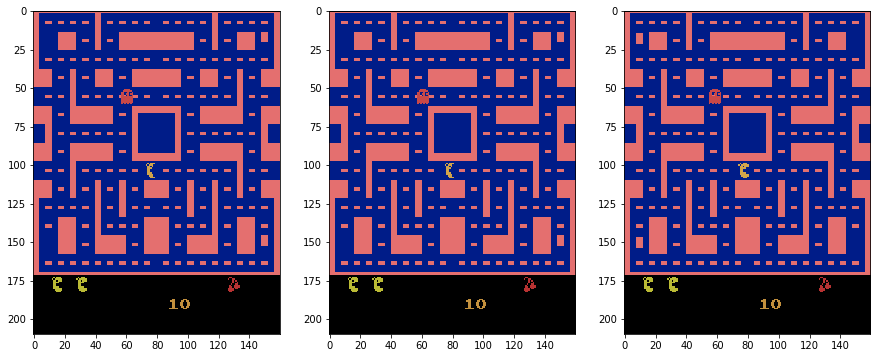

In [35]:
def display_sessions(max_n_sessions = 3):
    """just draw random images"""
    
    plt.figure(figsize=[15,8])
    
    pictures = [atari.render("rgb_array") for atari in pool.envs[:max_n_sessions]]
    for i,pic in enumerate(pictures):
        plt.subplot(1,max_n_sessions,i+1)
        plt.imshow(pic)
    plt.show()
    
#visualize untrained network performance (which is mostly random)
display_sessions()

In [38]:
import os
from agentnet.display import Metrics

score_log = Metrics()
epoch_counter = 1
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


epoch 26000,loss 3882.64923, epsilon 0.05000, rewards: ( e-greedy 57.15207, greedy 61.03759) 
rec 3870.251 reg 12.398
Learning curves:


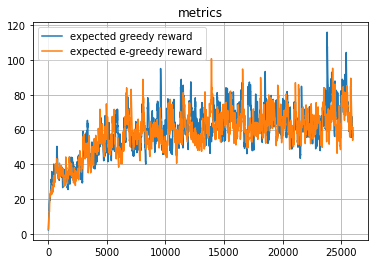

Random session examples


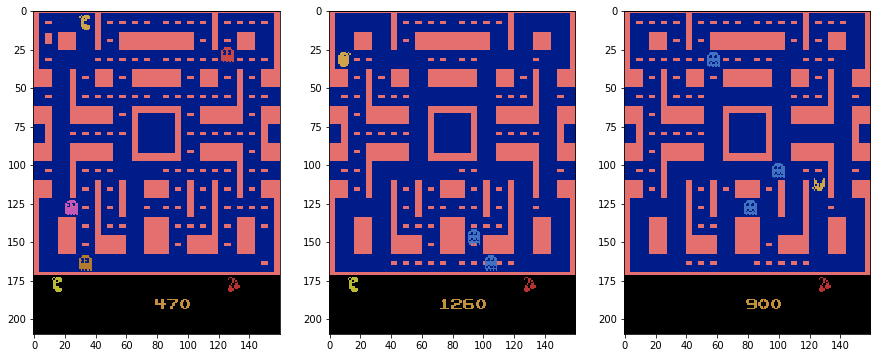

[2017-05-23 13:45:27,633] Making new env: MsPacman-v0
[2017-05-23 13:45:27,796] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-23 13:45:27,805] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.29.14344.video000000.mp4
[2017-05-23 13:45:29,276] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.29.14344.video000001.mp4


Episode finished after 523 timesteps, rw = 110.0
Episode finished after 888 timesteps, rw = 380.0
Episode finished after 689 timesteps, rw = 380.0
Episode finished after 525 timesteps, rw = 110.0
Episode finished after 427 timesteps, rw = 60.0
Episode finished after 542 timesteps, rw = 280.0
Episode finished after 514 timesteps, rw = 300.0


[2017-05-23 13:45:37,753] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.29.14344.video000008.mp4


Episode finished after 596 timesteps, rw = 110.0
Episode finished after 601 timesteps, rw = 110.0
Episode finished after 608 timesteps, rw = 270.0
Episode finished after 561 timesteps, rw = 110.0
Episode finished after 503 timesteps, rw = 110.0
Episode finished after 540 timesteps, rw = 110.0
Episode finished after 469 timesteps, rw = 110.0
Episode finished after 496 timesteps, rw = 110.0
Episode finished after 515 timesteps, rw = 80.0
Episode finished after 459 timesteps, rw = 110.0
Episode finished after 568 timesteps, rw = 120.0
Episode finished after 490 timesteps, rw = 130.0


[2017-05-23 13:45:50,202] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/fat_videos')


Episode finished after 507 timesteps, rw = 110.0
Mean 160.5, Var 9464.75
epoch 26010,loss 363.79688, epsilon 0.05000, rewards: ( e-greedy 56.18686, greedy 63.68383) 
rec 351.398 reg 12.399
epoch 26020,loss 830.74724, epsilon 0.05000, rewards: ( e-greedy 60.94318, greedy 61.81545) 
rec 818.349 reg 12.399
epoch 26030,loss 311.08075, epsilon 0.05000, rewards: ( e-greedy 58.84886, greedy 62.75890) 
rec 298.676 reg 12.405
epoch 26040,loss 435.14383, epsilon 0.05000, rewards: ( e-greedy 57.33897, greedy 58.48301) 
rec 422.728 reg 12.416
epoch 26050,loss 1187.61220, epsilon 0.05000, rewards: ( e-greedy 59.23008, greedy 67.13471) 
rec 1175.189 reg 12.423
epoch 26060,loss 751.10049, epsilon 0.05000, rewards: ( e-greedy 59.80707, greedy 65.29624) 
rec 738.664 reg 12.437
epoch 26070,loss 311.74533, epsilon 0.05000, rewards: ( e-greedy 59.07636, greedy 64.39162) 
rec 299.295 reg 12.450
epoch 26080,loss 242.31709, epsilon 0.05000, rewards: ( e-greedy 56.41872, greedy 64.07746) 
rec 229.861 reg 12.4

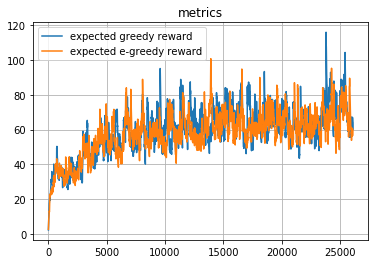

Random session examples


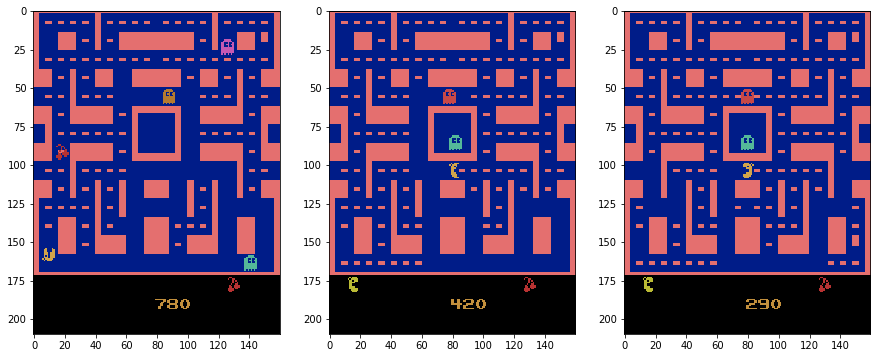

epoch 26110,loss 242.42481, epsilon 0.05000, rewards: ( e-greedy 55.94175, greedy 61.28371) 
rec 229.973 reg 12.452
epoch 26120,loss 2050.43632, epsilon 0.05000, rewards: ( e-greedy 60.84758, greedy 69.28034) 
rec 2037.984 reg 12.452
epoch 26130,loss 581.29510, epsilon 0.05000, rewards: ( e-greedy 61.38782, greedy 74.60231) 
rec 568.834 reg 12.461
epoch 26140,loss 3397.67377, epsilon 0.05000, rewards: ( e-greedy 64.87404, greedy 82.14208) 
rec 3385.192 reg 12.482
epoch 26150,loss 8710.45031, epsilon 0.05000, rewards: ( e-greedy 84.76163, greedy 77.55287) 
rec 8697.945 reg 12.505
epoch 26160,loss 296.47909, epsilon 0.05000, rewards: ( e-greedy 80.53547, greedy 77.54758) 
rec 283.942 reg 12.537
epoch 26170,loss 535.91996, epsilon 0.05000, rewards: ( e-greedy 75.35692, greedy 77.54282) 
rec 523.355 reg 12.565
epoch 26180,loss 1622.19936, epsilon 0.05000, rewards: ( e-greedy 77.57123, greedy 77.53854) 
rec 1609.589 reg 12.611
epoch 26190,loss 288.38322, epsilon 0.05000, rewards: ( e-greedy

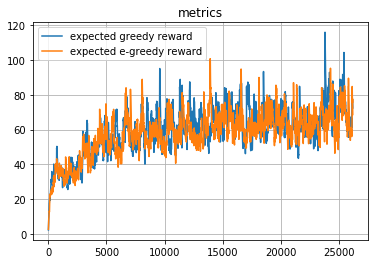

Random session examples


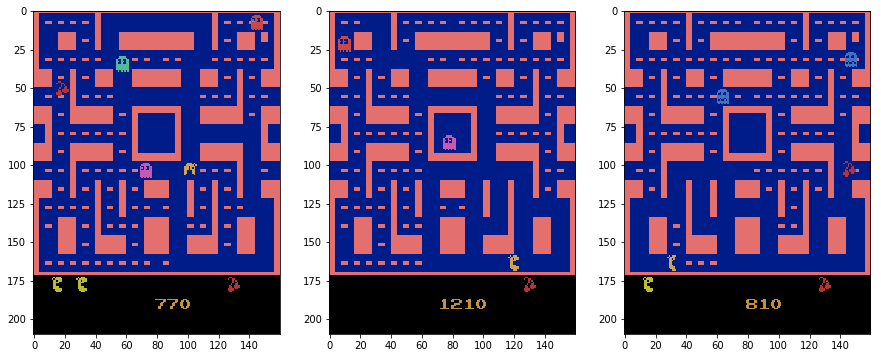

epoch 26210,loss 2963.39816, epsilon 0.05000, rewards: ( e-greedy 75.75818, greedy 71.89310) 
rec 2950.708 reg 12.690
epoch 26220,loss 386.35105, epsilon 0.05000, rewards: ( e-greedy 72.05736, greedy 73.82879) 
rec 373.661 reg 12.690
epoch 26230,loss 259.15506, epsilon 0.05000, rewards: ( e-greedy 68.85162, greedy 71.69591) 
rec 246.462 reg 12.693
epoch 26240,loss 944.28347, epsilon 0.05000, rewards: ( e-greedy 69.21646, greedy 75.90132) 
rec 931.593 reg 12.690
epoch 26250,loss 4083.07728, epsilon 0.05000, rewards: ( e-greedy 87.79481, greedy 72.18619) 
rec 4070.393 reg 12.684
epoch 26260,loss 211.52115, epsilon 0.05000, rewards: ( e-greedy 82.89033, greedy 68.09257) 
rec 198.837 reg 12.685
epoch 26270,loss 395.61776, epsilon 0.05000, rewards: ( e-greedy 79.35130, greedy 65.78331) 
rec 382.946 reg 12.672
epoch 26280,loss 395.29931, epsilon 0.05000, rewards: ( e-greedy 76.04117, greedy 72.20498) 
rec 382.641 reg 12.658
epoch 26290,loss 320.26167, epsilon 0.05000, rewards: ( e-greedy 72.

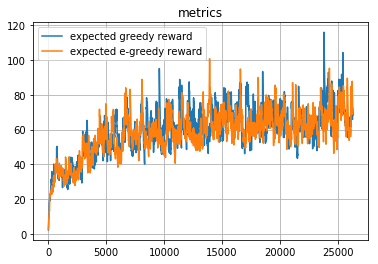

Random session examples


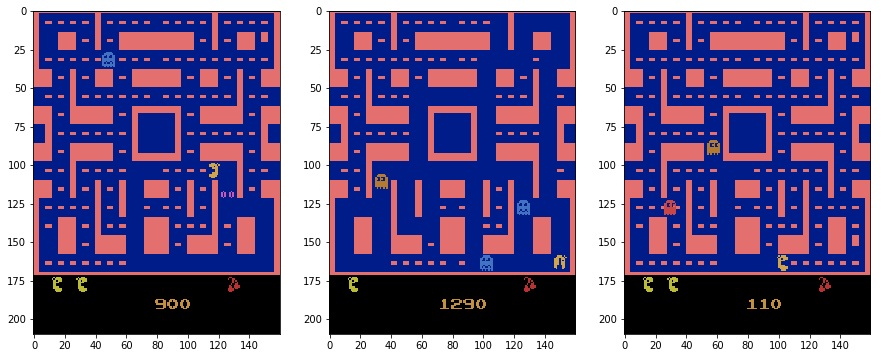

epoch 26310,loss 157.20619, epsilon 0.05000, rewards: ( e-greedy 65.72901, greedy 65.70743) 
rec 144.593 reg 12.614
epoch 26320,loss 1702.14915, epsilon 0.05000, rewards: ( e-greedy 69.78111, greedy 74.88669) 
rec 1689.545 reg 12.604
epoch 26330,loss 383.31856, epsilon 0.05000, rewards: ( e-greedy 66.05300, greedy 73.77302) 
rec 370.722 reg 12.597
epoch 26340,loss 2966.85702, epsilon 0.05000, rewards: ( e-greedy 73.07270, greedy 72.64572) 
rec 2954.264 reg 12.593
epoch 26350,loss 361.94127, epsilon 0.05000, rewards: ( e-greedy 70.01543, greedy 68.25614) 
rec 349.342 reg 12.599
epoch 26360,loss 244.15016, epsilon 0.05000, rewards: ( e-greedy 63.38889, greedy 62.68053) 
rec 231.544 reg 12.606
epoch 26370,loss 975.24528, epsilon 0.05000, rewards: ( e-greedy 67.30000, greedy 62.66248) 
rec 962.636 reg 12.609
epoch 26380,loss 1521.33479, epsilon 0.05000, rewards: ( e-greedy 70.69500, greedy 63.64623) 
rec 1508.727 reg 12.607
epoch 26390,loss 285.62345, epsilon 0.05000, rewards: ( e-greedy 6

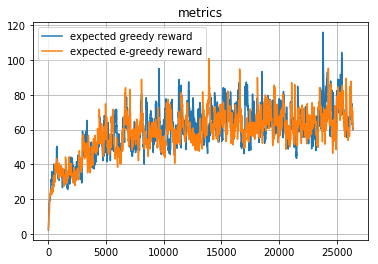

Random session examples


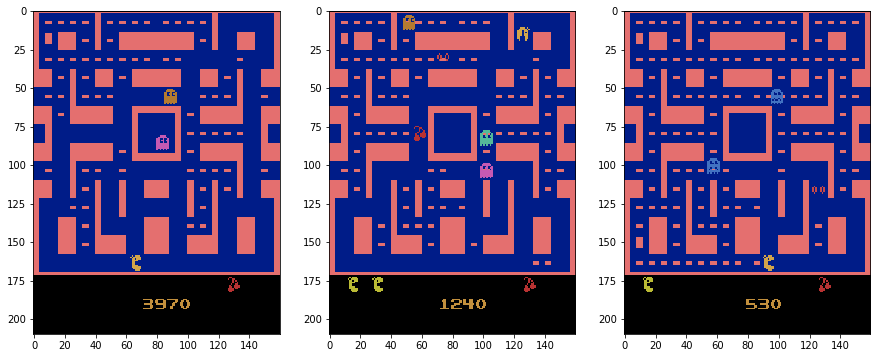

epoch 26410,loss 1729.77384, epsilon 0.05000, rewards: ( e-greedy 65.95165, greedy 59.32435) 
rec 1717.154 reg 12.620
epoch 26420,loss 1165.77410, epsilon 0.05000, rewards: ( e-greedy 66.73149, greedy 56.39192) 
rec 1153.140 reg 12.634
epoch 26430,loss 1037.52632, epsilon 0.05000, rewards: ( e-greedy 69.80834, greedy 63.12772) 
rec 1024.884 reg 12.643
epoch 26440,loss 2565.88611, epsilon 0.05000, rewards: ( e-greedy 71.70251, greedy 60.31495) 
rec 2553.245 reg 12.641
epoch 26450,loss 1594.11432, epsilon 0.05000, rewards: ( e-greedy 74.15726, greedy 59.53346) 
rec 1581.479 reg 12.635
epoch 26460,loss 326.15174, epsilon 0.05000, rewards: ( e-greedy 70.11653, greedy 54.95511) 
rec 313.525 reg 12.627
epoch 26470,loss 339.54581, epsilon 0.05000, rewards: ( e-greedy 66.22988, greedy 70.95960) 
rec 326.925 reg 12.621
epoch 26480,loss 255.84775, epsilon 0.05000, rewards: ( e-greedy 65.35689, greedy 66.98864) 
rec 243.237 reg 12.610
epoch 26490,loss 2458.04473, epsilon 0.05000, rewards: ( e-gre

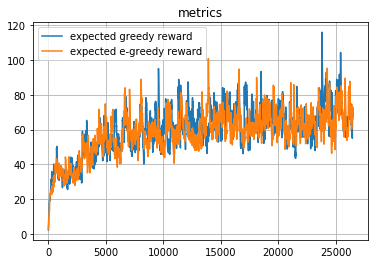

Random session examples


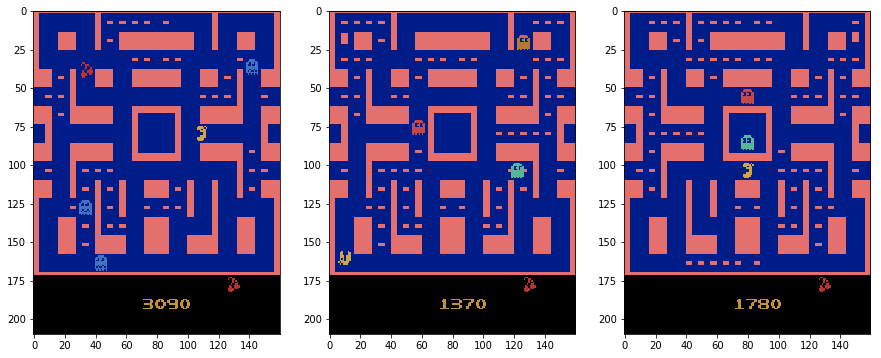

epoch 26510,loss 436.67557, epsilon 0.05000, rewards: ( e-greedy 66.87392, greedy 72.87972) 
rec 424.066 reg 12.609
epoch 26520,loss 277.91394, epsilon 0.05000, rewards: ( e-greedy 63.93653, greedy 69.09175) 
rec 265.310 reg 12.604
epoch 26530,loss 2201.43277, epsilon 0.05000, rewards: ( e-greedy 68.04288, greedy 66.93257) 
rec 2188.834 reg 12.599
epoch 26540,loss 600.72121, epsilon 0.05000, rewards: ( e-greedy 67.23859, greedy 68.73931) 
rec 588.127 reg 12.594
epoch 26550,loss 225.34206, epsilon 0.05000, rewards: ( e-greedy 62.88973, greedy 66.61538) 
rec 212.742 reg 12.600
epoch 26560,loss 331.24563, epsilon 0.05000, rewards: ( e-greedy 60.35076, greedy 64.82885) 
rec 318.634 reg 12.612
epoch 26570,loss 5556.62469, epsilon 0.05000, rewards: ( e-greedy 76.69068, greedy 64.97096) 
rec 5544.007 reg 12.618
epoch 26580,loss 249.83474, epsilon 0.05000, rewards: ( e-greedy 72.27161, greedy 62.72386) 
rec 237.210 reg 12.625
epoch 26590,loss 925.35284, epsilon 0.05000, rewards: ( e-greedy 70.

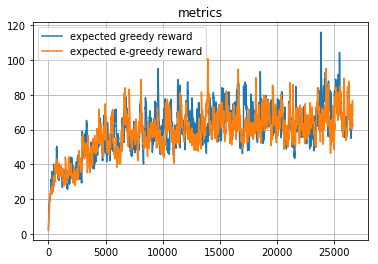

Random session examples


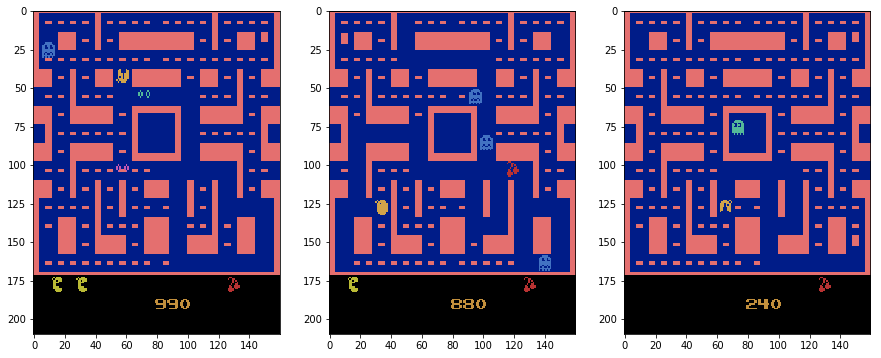

epoch 26610,loss 722.30866, epsilon 0.05000, rewards: ( e-greedy 72.03976, greedy 61.86070) 
rec 709.695 reg 12.613
epoch 26620,loss 239.62812, epsilon 0.05000, rewards: ( e-greedy 67.21078, greedy 59.79963) 
rec 227.013 reg 12.616
epoch 26630,loss 3802.34073, epsilon 0.05000, rewards: ( e-greedy 73.36470, greedy 77.31966) 
rec 3789.722 reg 12.619
epoch 26640,loss 254.46650, epsilon 0.05000, rewards: ( e-greedy 68.52823, greedy 73.21270) 
rec 241.844 reg 12.622
epoch 26650,loss 347.71670, epsilon 0.05000, rewards: ( e-greedy 65.30041, greedy 70.89143) 
rec 335.096 reg 12.621
epoch 26660,loss 1145.72004, epsilon 0.05000, rewards: ( e-greedy 66.27037, greedy 70.17729) 
rec 1133.103 reg 12.617
epoch 26670,loss 952.25769, epsilon 0.05000, rewards: ( e-greedy 71.14333, greedy 83.78456) 
rec 939.640 reg 12.618
epoch 26680,loss 330.91509, epsilon 0.05000, rewards: ( e-greedy 69.52900, greedy 85.78110) 
rec 318.298 reg 12.617
epoch 26690,loss 268.12038, epsilon 0.05000, rewards: ( e-greedy 64.

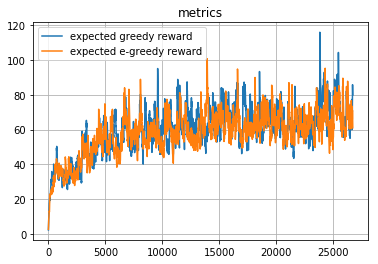

Random session examples


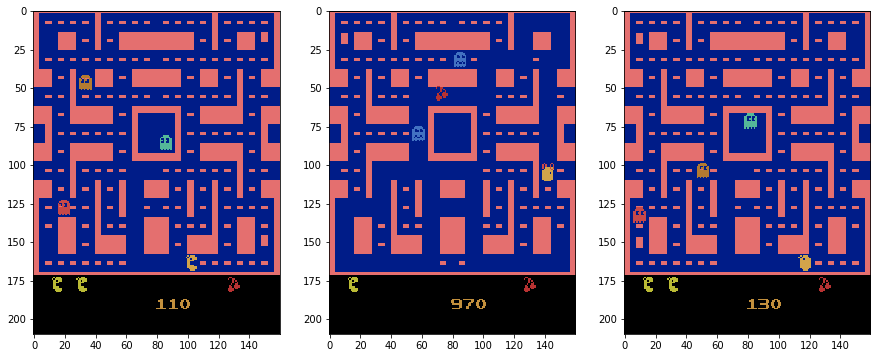

epoch 26710,loss 297.41736, epsilon 0.05000, rewards: ( e-greedy 59.64414, greedy 78.01942) 
rec 284.791 reg 12.626
epoch 26720,loss 387.61226, epsilon 0.05000, rewards: ( e-greedy 59.55473, greedy 83.96748) 
rec 374.982 reg 12.630
epoch 26730,loss 1268.56850, epsilon 0.05000, rewards: ( e-greedy 63.97425, greedy 91.82073) 
rec 1255.937 reg 12.631
epoch 26740,loss 9099.81646, epsilon 0.05000, rewards: ( e-greedy 79.57683, greedy 88.51366) 
rec 9087.187 reg 12.630
epoch 26750,loss 990.76989, epsilon 0.05000, rewards: ( e-greedy 82.11915, greedy 85.16229) 
rec 978.144 reg 12.626
epoch 26760,loss 381.60173, epsilon 0.05000, rewards: ( e-greedy 77.40723, greedy 78.64606) 
rec 368.983 reg 12.619
epoch 26770,loss 268.93213, epsilon 0.05000, rewards: ( e-greedy 74.04151, greedy 78.03146) 
rec 256.325 reg 12.608
epoch 26780,loss 1128.51407, epsilon 0.05000, rewards: ( e-greedy 73.13736, greedy 74.22831) 
rec 1115.909 reg 12.605
epoch 26790,loss 700.07623, epsilon 0.05000, rewards: ( e-greedy 7

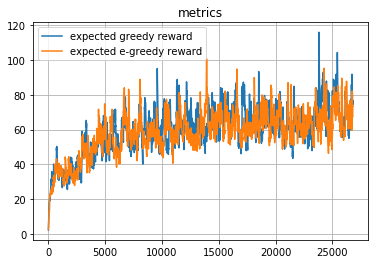

Random session examples


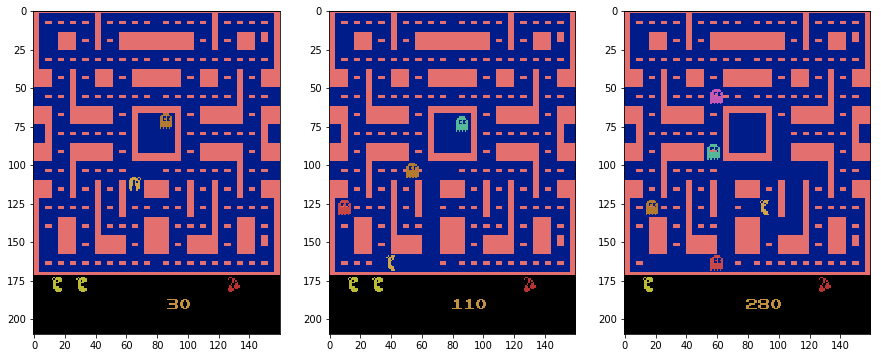

epoch 26810,loss 602.12250, epsilon 0.05000, rewards: ( e-greedy 65.95838, greedy 78.14994) 
rec 589.508 reg 12.615
epoch 26820,loss 602.34000, epsilon 0.05000, rewards: ( e-greedy 64.11254, greedy 74.70995) 
rec 589.684 reg 12.656
epoch 26830,loss 719.77897, epsilon 0.05000, rewards: ( e-greedy 65.82629, greedy 74.61395) 
rec 707.090 reg 12.689
epoch 26840,loss 294.97643, epsilon 0.05000, rewards: ( e-greedy 62.24366, greedy 74.15256) 
rec 282.259 reg 12.717
epoch 26850,loss 893.26386, epsilon 0.05000, rewards: ( e-greedy 61.14430, greedy 73.36230) 
rec 880.489 reg 12.775
epoch 26860,loss 467.32618, epsilon 0.05000, rewards: ( e-greedy 57.40487, greedy 70.77607) 
rec 454.465 reg 12.861
epoch 26870,loss 651.84760, epsilon 0.05000, rewards: ( e-greedy 58.66438, greedy 71.94846) 
rec 638.940 reg 12.908
epoch 26880,loss 1065.26427, epsilon 0.05000, rewards: ( e-greedy 57.54794, greedy 67.25362) 
rec 1052.310 reg 12.955
epoch 26890,loss 768.91596, epsilon 0.05000, rewards: ( e-greedy 56.16

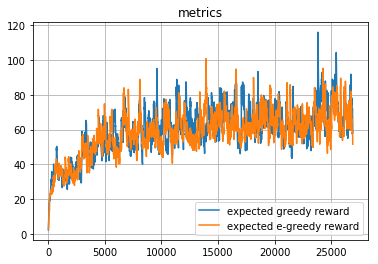

Random session examples


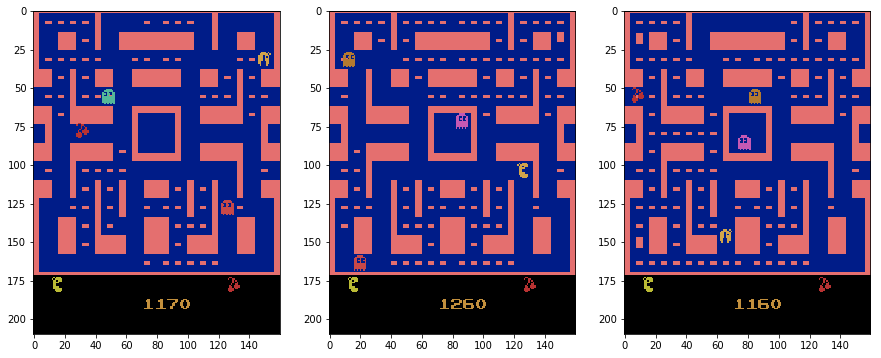

epoch 26910,loss 2613.44929, epsilon 0.05000, rewards: ( e-greedy 62.64620, greedy 55.59789) 
rec 2600.394 reg 13.055
epoch 26920,loss 302.13203, epsilon 0.05000, rewards: ( e-greedy 59.38158, greedy 54.03810) 
rec 289.058 reg 13.074
epoch 26930,loss 565.21843, epsilon 0.05000, rewards: ( e-greedy 58.94342, greedy 53.63429) 
rec 552.142 reg 13.077
epoch 26940,loss 424.54147, epsilon 0.05000, rewards: ( e-greedy 60.42408, greedy 54.14586) 
rec 411.468 reg 13.074
epoch 26950,loss 393.28093, epsilon 0.05000, rewards: ( e-greedy 60.50667, greedy 56.73127) 
rec 380.213 reg 13.068
epoch 26960,loss 248.77318, epsilon 0.05000, rewards: ( e-greedy 58.83100, greedy 56.80815) 
rec 235.715 reg 13.058
epoch 26970,loss 150.07747, epsilon 0.05000, rewards: ( e-greedy 56.07290, greedy 55.25233) 
rec 137.031 reg 13.046
epoch 26980,loss 1397.30101, epsilon 0.05000, rewards: ( e-greedy 62.21561, greedy 56.60210) 
rec 1384.258 reg 13.043
epoch 26990,loss 207.15785, epsilon 0.05000, rewards: ( e-greedy 59.

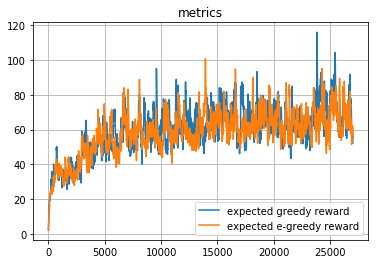

Random session examples


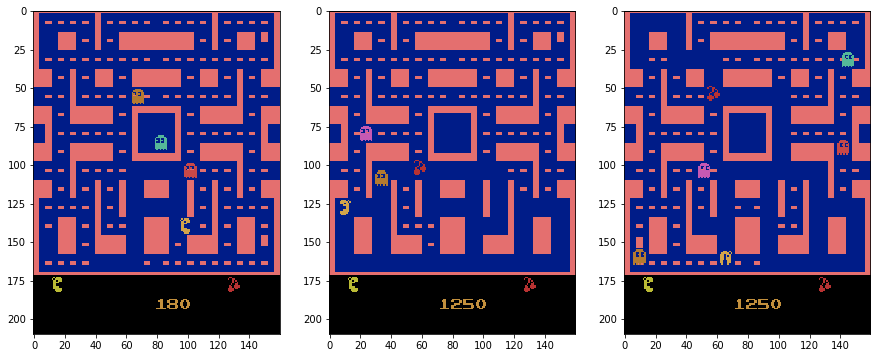

[2017-05-23 13:58:22,115] Making new env: MsPacman-v0
[2017-05-23 13:58:22,277] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-23 13:58:22,286] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.30.14344.video000000.mp4
[2017-05-23 13:58:24,107] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.30.14344.video000001.mp4


Episode finished after 693 timesteps, rw = 180.0
Episode finished after 814 timesteps, rw = 780.0
Episode finished after 584 timesteps, rw = 160.0
Episode finished after 517 timesteps, rw = 60.0
Episode finished after 450 timesteps, rw = 110.0
Episode finished after 770 timesteps, rw = 430.0
Episode finished after 427 timesteps, rw = 60.0


[2017-05-23 13:58:32,277] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.30.14344.video000008.mp4


Episode finished after 429 timesteps, rw = 60.0
Episode finished after 564 timesteps, rw = 110.0
Episode finished after 574 timesteps, rw = 110.0
Episode finished after 429 timesteps, rw = 60.0
Episode finished after 885 timesteps, rw = 180.0
Episode finished after 434 timesteps, rw = 60.0
Episode finished after 586 timesteps, rw = 110.0
Episode finished after 453 timesteps, rw = 110.0
Episode finished after 822 timesteps, rw = 380.0
Episode finished after 433 timesteps, rw = 60.0
Episode finished after 776 timesteps, rw = 780.0
Episode finished after 507 timesteps, rw = 110.0


[2017-05-23 13:58:46,039] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/fat_videos')


Episode finished after 459 timesteps, rw = 110.0
Mean 201.0, Var 46739.0
epoch 27010,loss 1056.28859, epsilon 0.05000, rewards: ( e-greedy 61.86518, greedy 59.77418) 
rec 1043.210 reg 13.078
epoch 27020,loss 449.52718, epsilon 0.05000, rewards: ( e-greedy 62.05366, greedy 56.29676) 
rec 436.447 reg 13.080
epoch 27030,loss 512.98024, epsilon 0.05000, rewards: ( e-greedy 60.97330, greedy 54.04209) 
rec 499.903 reg 13.077
epoch 27040,loss 290.09342, epsilon 0.05000, rewards: ( e-greedy 61.50097, greedy 56.76288) 
rec 277.020 reg 13.073
epoch 27050,loss 1561.59248, epsilon 0.05000, rewards: ( e-greedy 60.10087, greedy 69.71159) 
rec 1548.520 reg 13.072
epoch 27060,loss 142.33814, epsilon 0.05000, rewards: ( e-greedy 56.46578, greedy 67.61543) 
rec 129.277 reg 13.061
epoch 27070,loss 252.98950, epsilon 0.05000, rewards: ( e-greedy 53.69421, greedy 69.72889) 
rec 239.944 reg 13.046
epoch 27080,loss 639.39356, epsilon 0.05000, rewards: ( e-greedy 56.94978, greedy 66.00600) 
rec 626.362 reg 13

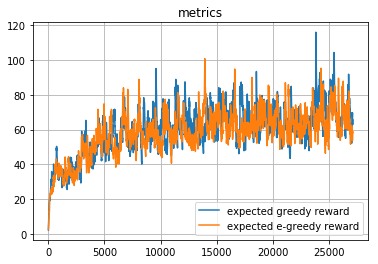

Random session examples


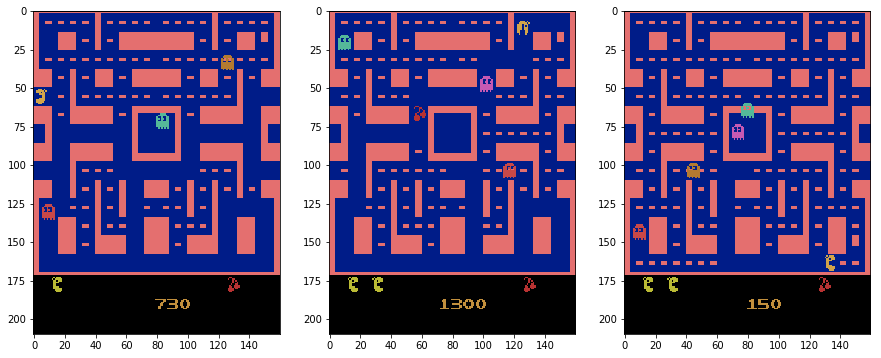

epoch 27110,loss 281.11579, epsilon 0.05000, rewards: ( e-greedy 54.66764, greedy 63.07712) 
rec 268.096 reg 13.020
epoch 27120,loss 904.40467, epsilon 0.05000, rewards: ( e-greedy 56.95088, greedy 68.01941) 
rec 891.386 reg 13.018
epoch 27130,loss 213.37811, epsilon 0.05000, rewards: ( e-greedy 55.00579, greedy 68.34247) 
rec 200.365 reg 13.013
epoch 27140,loss 477.70555, epsilon 0.05000, rewards: ( e-greedy 54.88021, greedy 70.00822) 
rec 464.698 reg 13.007
epoch 27150,loss 1037.27993, epsilon 0.05000, rewards: ( e-greedy 54.26719, greedy 72.25740) 
rec 1024.282 reg 12.997
epoch 27160,loss 1045.50300, epsilon 0.05000, rewards: ( e-greedy 59.71547, greedy 72.40666) 
rec 1032.520 reg 12.983
epoch 27170,loss 475.80267, epsilon 0.05000, rewards: ( e-greedy 57.74392, greedy 71.79099) 
rec 462.835 reg 12.968
epoch 27180,loss 527.81321, epsilon 0.05000, rewards: ( e-greedy 60.21953, greedy 77.48689) 
rec 514.852 reg 12.961
epoch 27190,loss 274.67693, epsilon 0.05000, rewards: ( e-greedy 58.

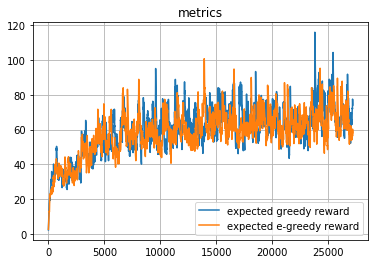

Random session examples


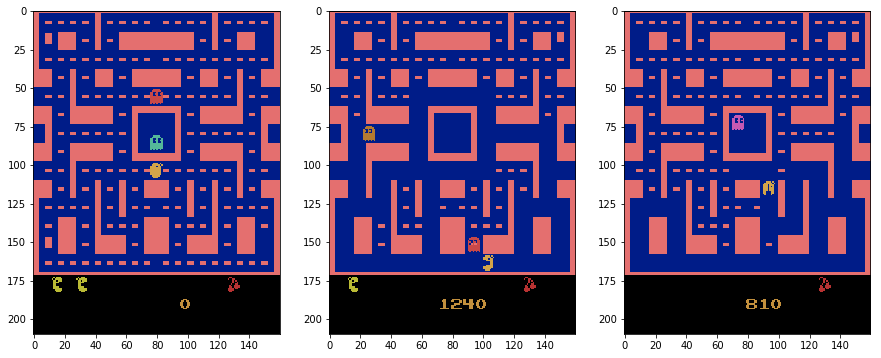

epoch 27210,loss 706.76334, epsilon 0.05000, rewards: ( e-greedy 59.20379, greedy 83.64670) 
rec 693.822 reg 12.941
epoch 27220,loss 142.35319, epsilon 0.05000, rewards: ( e-greedy 56.15841, greedy 78.53203) 
rec 129.418 reg 12.936
epoch 27230,loss 279.75472, epsilon 0.05000, rewards: ( e-greedy 54.29257, greedy 75.17882) 
rec 266.829 reg 12.926
epoch 27240,loss 2333.03513, epsilon 0.05000, rewards: ( e-greedy 58.73831, greedy 73.66094) 
rec 2320.111 reg 12.925
epoch 27250,loss 259.13990, epsilon 0.05000, rewards: ( e-greedy 56.61448, greedy 69.91985) 
rec 246.219 reg 12.921
epoch 27260,loss 374.64518, epsilon 0.05000, rewards: ( e-greedy 55.82803, greedy 71.30286) 
rec 361.729 reg 12.916
epoch 27270,loss 469.77767, epsilon 0.05000, rewards: ( e-greedy 56.62023, greedy 71.92258) 
rec 456.869 reg 12.909
epoch 27280,loss 219.46961, epsilon 0.05000, rewards: ( e-greedy 53.95821, greedy 68.60532) 
rec 206.572 reg 12.898
epoch 27290,loss 883.09109, epsilon 0.05000, rewards: ( e-greedy 59.81

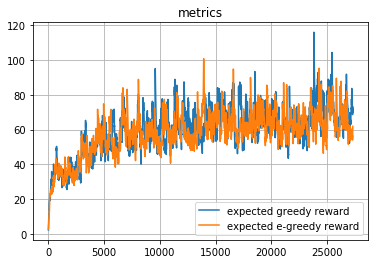

Random session examples


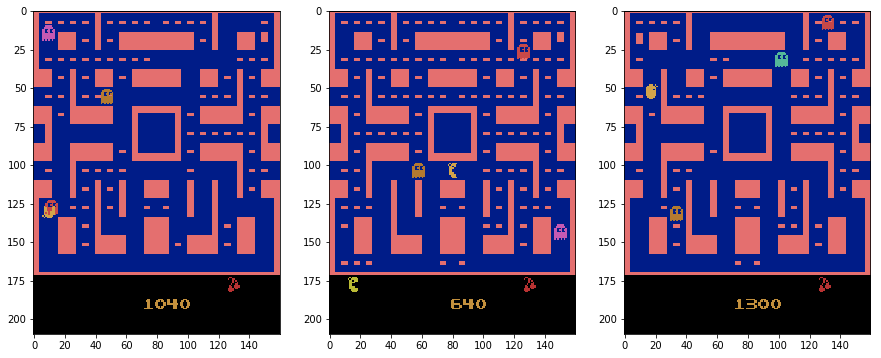

epoch 27310,loss 1128.79010, epsilon 0.05000, rewards: ( e-greedy 62.64803, greedy 69.79078) 
rec 1115.888 reg 12.902
epoch 27320,loss 1052.88620, epsilon 0.05000, rewards: ( e-greedy 62.00823, greedy 65.81170) 
rec 1039.988 reg 12.898
epoch 27330,loss 294.54239, epsilon 0.05000, rewards: ( e-greedy 60.05741, greedy 66.98053) 
rec 281.651 reg 12.891
epoch 27340,loss 249.36831, epsilon 0.05000, rewards: ( e-greedy 59.05167, greedy 68.15748) 
rec 236.484 reg 12.885
epoch 27350,loss 1987.47039, epsilon 0.05000, rewards: ( e-greedy 64.89650, greedy 63.59173) 
rec 1974.593 reg 12.877
epoch 27360,loss 347.79359, epsilon 0.05000, rewards: ( e-greedy 64.03185, greedy 60.23256) 
rec 334.920 reg 12.873
epoch 27370,loss 561.66666, epsilon 0.05000, rewards: ( e-greedy 66.75366, greedy 58.20930) 
rec 548.794 reg 12.873
epoch 27380,loss 337.37271, epsilon 0.05000, rewards: ( e-greedy 63.45330, greedy 59.38837) 
rec 324.507 reg 12.866
epoch 27390,loss 276.89310, epsilon 0.05000, rewards: ( e-greedy 6

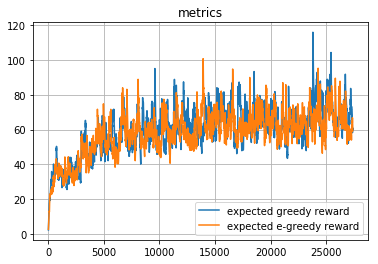

Random session examples


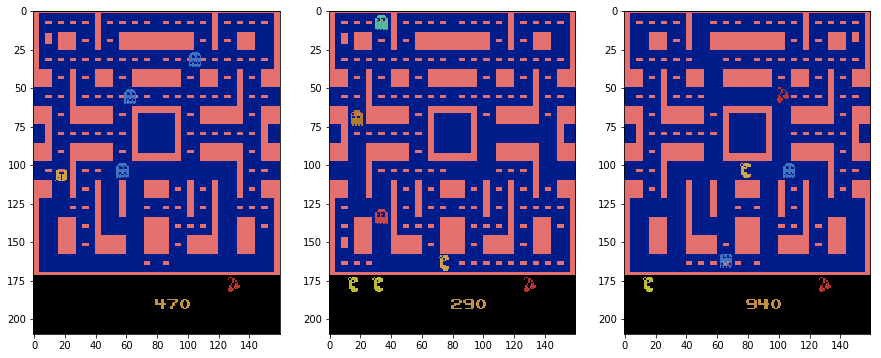

epoch 27410,loss 261.33894, epsilon 0.05000, rewards: ( e-greedy 55.87745, greedy 57.48162) 
rec 248.483 reg 12.856
epoch 27420,loss 451.80582, epsilon 0.05000, rewards: ( e-greedy 52.78971, greedy 55.60846) 
rec 438.945 reg 12.861
epoch 27430,loss 1048.15770, epsilon 0.05000, rewards: ( e-greedy 59.26074, greedy 55.54761) 
rec 1035.294 reg 12.864
epoch 27440,loss 804.89827, epsilon 0.05000, rewards: ( e-greedy 60.08466, greedy 57.36785) 
rec 792.042 reg 12.856
epoch 27450,loss 688.56993, epsilon 0.05000, rewards: ( e-greedy 63.32620, greedy 60.63107) 
rec 675.721 reg 12.849
epoch 27460,loss 261.78988, epsilon 0.05000, rewards: ( e-greedy 61.61858, greedy 58.94296) 
rec 248.951 reg 12.839
epoch 27470,loss 1305.52775, epsilon 0.05000, rewards: ( e-greedy 64.70672, greedy 70.79866) 
rec 1292.700 reg 12.827
epoch 27480,loss 626.89798, epsilon 0.05000, rewards: ( e-greedy 63.61105, greedy 71.59380) 
rec 614.073 reg 12.825
epoch 27490,loss 10202.43648, epsilon 0.05000, rewards: ( e-greedy 7

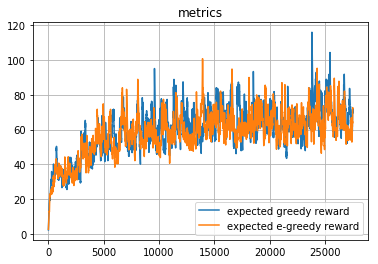

Random session examples


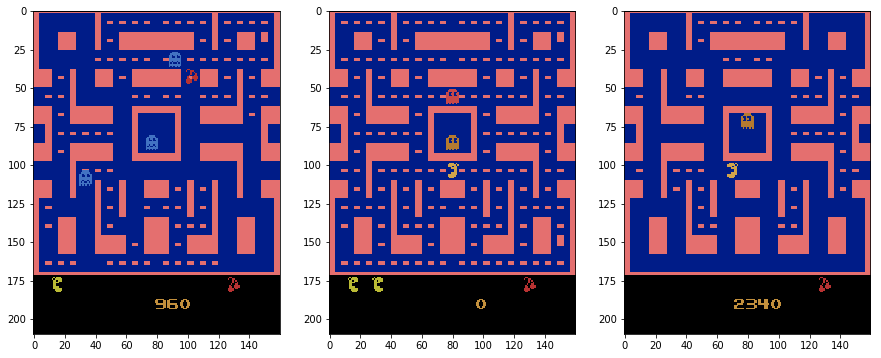

epoch 27510,loss 17052.71166, epsilon 0.05000, rewards: ( e-greedy 89.88870, greedy 66.31563) 
rec 17039.889 reg 12.823
epoch 27520,loss 357.02200, epsilon 0.05000, rewards: ( e-greedy 84.27483, greedy 65.68407) 
rec 344.197 reg 12.825
epoch 27530,loss 1637.84407, epsilon 0.05000, rewards: ( e-greedy 89.84735, greedy 66.49066) 
rec 1625.022 reg 12.822
epoch 27540,loss 2510.10473, epsilon 0.05000, rewards: ( e-greedy 90.61262, greedy 71.84159) 
rec 2497.289 reg 12.816
epoch 27550,loss 333.94607, epsilon 0.05000, rewards: ( e-greedy 86.55135, greedy 72.15743) 
rec 321.142 reg 12.804
epoch 27560,loss 1820.00328, epsilon 0.05000, rewards: ( e-greedy 89.39622, greedy 74.06669) 
rec 1807.210 reg 12.793
epoch 27570,loss 483.11498, epsilon 0.05000, rewards: ( e-greedy 88.45660, greedy 72.78502) 
rec 470.329 reg 12.786
epoch 27580,loss 358.85356, epsilon 0.05000, rewards: ( e-greedy 86.23594, greedy 73.00652) 
rec 346.078 reg 12.776
epoch 27590,loss 670.26335, epsilon 0.05000, rewards: ( e-gree

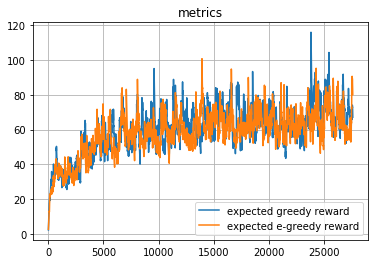

Random session examples


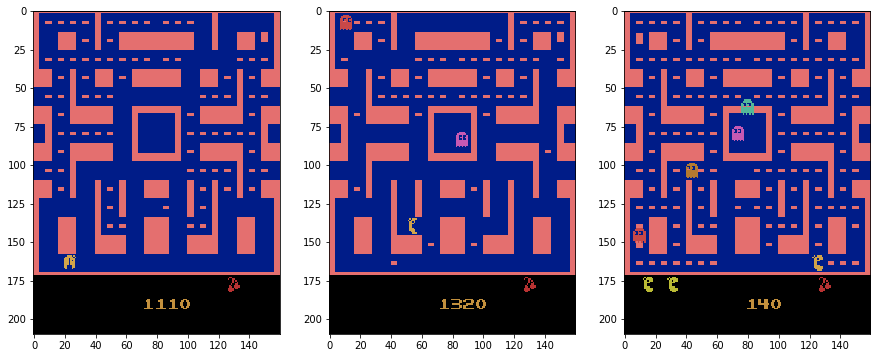

epoch 27610,loss 448.81284, epsilon 0.05000, rewards: ( e-greedy 76.85225, greedy 62.61550) 
rec 436.059 reg 12.754
epoch 27620,loss 224.61488, epsilon 0.05000, rewards: ( e-greedy 71.16702, greedy 62.47895) 
rec 211.867 reg 12.748
epoch 27630,loss 182.18190, epsilon 0.05000, rewards: ( e-greedy 67.17532, greedy 59.98106) 
rec 169.436 reg 12.746
epoch 27640,loss 539.63102, epsilon 0.05000, rewards: ( e-greedy 66.70779, greedy 61.10795) 
rec 526.894 reg 12.737
epoch 27650,loss 347.85264, epsilon 0.05000, rewards: ( e-greedy 67.28701, greedy 62.74716) 
rec 335.125 reg 12.728
epoch 27660,loss 700.79820, epsilon 0.05000, rewards: ( e-greedy 67.05831, greedy 57.59744) 
rec 688.072 reg 12.726
epoch 27670,loss 360.39786, epsilon 0.05000, rewards: ( e-greedy 64.10248, greedy 58.83770) 
rec 347.677 reg 12.721
epoch 27680,loss 1371.19340, epsilon 0.05000, rewards: ( e-greedy 69.06723, greedy 63.45393) 
rec 1358.481 reg 12.712
epoch 27690,loss 1199.02819, epsilon 0.05000, rewards: ( e-greedy 72.0

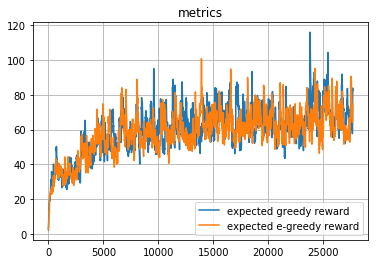

Random session examples


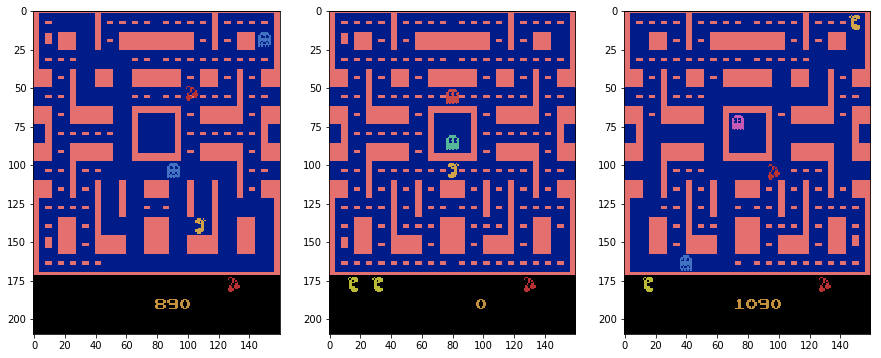

epoch 27710,loss 194.71184, epsilon 0.05000, rewards: ( e-greedy 70.11126, greedy 79.23791) 
rec 182.030 reg 12.682
epoch 27720,loss 2160.94464, epsilon 0.05000, rewards: ( e-greedy 73.60013, greedy 77.81412) 
rec 2148.243 reg 12.702
epoch 27730,loss 257.34373, epsilon 0.05000, rewards: ( e-greedy 68.61512, greedy 73.40771) 
rec 244.609 reg 12.735
epoch 27740,loss 13387.07330, epsilon 0.05000, rewards: ( e-greedy 82.87861, greedy 97.19194) 
rec 13374.306 reg 12.768
epoch 27750,loss 261.99582, epsilon 0.05000, rewards: ( e-greedy 77.71575, greedy 93.47274) 
rec 249.180 reg 12.816
epoch 27760,loss 472.20773, epsilon 0.05000, rewards: ( e-greedy 74.56917, greedy 91.00047) 
rec 459.361 reg 12.847
epoch 27770,loss 566.23381, epsilon 0.05000, rewards: ( e-greedy 74.36226, greedy 86.02542) 
rec 553.367 reg 12.867
epoch 27780,loss 1813.43570, epsilon 0.05000, rewards: ( e-greedy 76.80103, greedy 83.67288) 
rec 1800.559 reg 12.876
epoch 27790,loss 213.56329, epsilon 0.05000, rewards: ( e-greedy

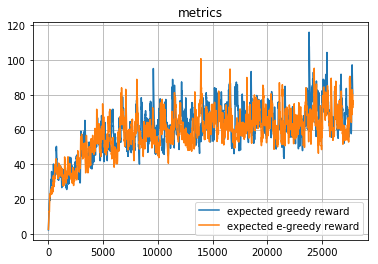

Random session examples


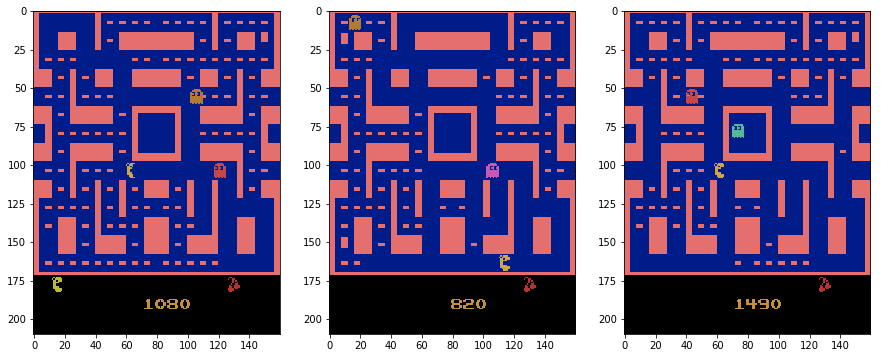

epoch 27810,loss 288.59499, epsilon 0.05000, rewards: ( e-greedy 76.98420, greedy 76.97128) 
rec 275.682 reg 12.913
epoch 27820,loss 376.81268, epsilon 0.05000, rewards: ( e-greedy 72.66078, greedy 71.27415) 
rec 363.886 reg 12.927
epoch 27830,loss 337.98137, epsilon 0.05000, rewards: ( e-greedy 71.26970, greedy 72.27174) 
rec 325.041 reg 12.940
epoch 27840,loss 238.53721, epsilon 0.05000, rewards: ( e-greedy 66.14273, greedy 69.16956) 
rec 225.593 reg 12.944
epoch 27850,loss 380.49436, epsilon 0.05000, rewards: ( e-greedy 63.77846, greedy 66.62761) 
rec 367.547 reg 12.948
epoch 27860,loss 1063.74629, epsilon 0.05000, rewards: ( e-greedy 62.27561, greedy 61.33985) 
rec 1050.790 reg 12.957
epoch 27870,loss 323.71281, epsilon 0.05000, rewards: ( e-greedy 59.79805, greedy 59.08086) 
rec 310.754 reg 12.958
epoch 27880,loss 1024.36332, epsilon 0.05000, rewards: ( e-greedy 60.56825, greedy 57.92278) 
rec 1011.412 reg 12.951
epoch 27890,loss 1026.57669, epsilon 0.05000, rewards: ( e-greedy 61

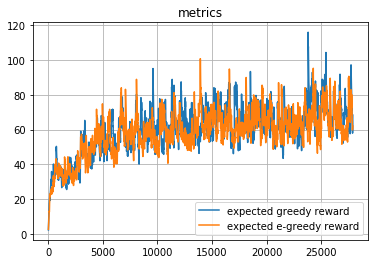

Random session examples


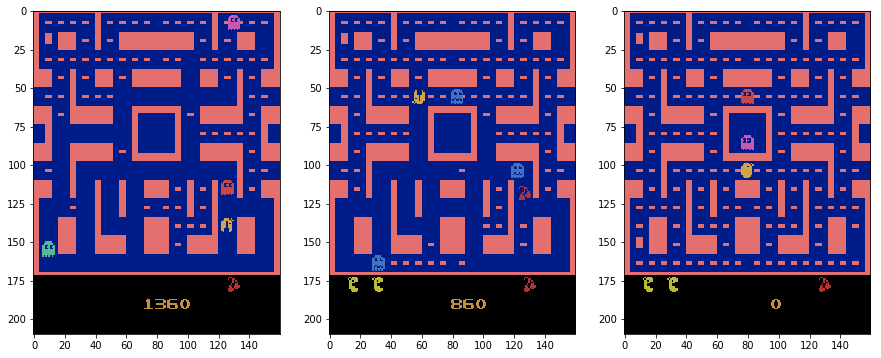

epoch 27910,loss 280.69960, epsilon 0.05000, rewards: ( e-greedy 57.57050, greedy 63.22445) 
rec 267.761 reg 12.939
epoch 27920,loss 12499.25350, epsilon 0.05000, rewards: ( e-greedy 67.56345, greedy 73.27701) 
rec 12486.310 reg 12.944
epoch 27930,loss 301.84661, epsilon 0.05000, rewards: ( e-greedy 63.43211, greedy 69.94931) 
rec 288.892 reg 12.954
epoch 27940,loss 1267.92297, epsilon 0.05000, rewards: ( e-greedy 65.21390, greedy 65.20438) 
rec 1254.964 reg 12.958
epoch 27950,loss 297.96298, epsilon 0.05000, rewards: ( e-greedy 62.06751, greedy 61.18394) 
rec 285.010 reg 12.953
epoch 27960,loss 286.52921, epsilon 0.05000, rewards: ( e-greedy 58.23576, greedy 62.56554) 
rec 273.584 reg 12.945
epoch 27970,loss 376.67976, epsilon 0.05000, rewards: ( e-greedy 57.53718, greedy 64.05899) 
rec 363.742 reg 12.938
epoch 27980,loss 450.07971, epsilon 0.05000, rewards: ( e-greedy 57.90846, greedy 65.77809) 
rec 437.150 reg 12.929
epoch 27990,loss 363.56577, epsilon 0.05000, rewards: ( e-greedy 5

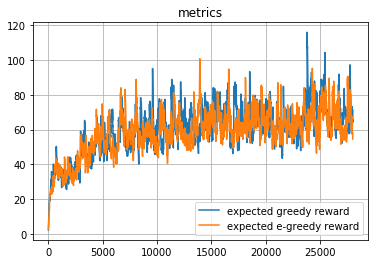

Random session examples


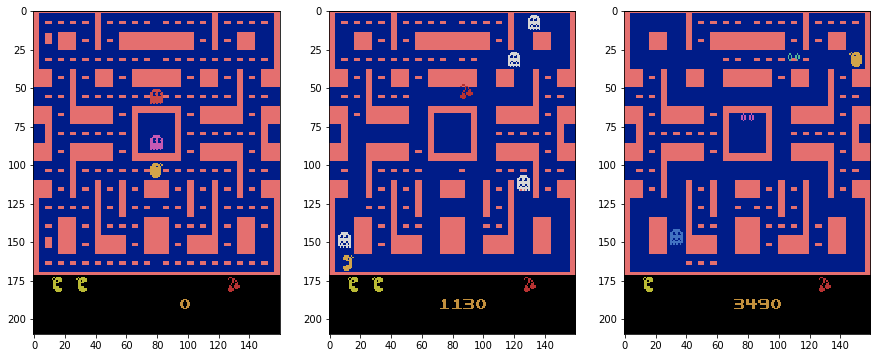

[2017-05-23 14:11:16,889] Making new env: MsPacman-v0
[2017-05-23 14:11:17,054] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-23 14:11:17,062] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.31.14344.video000000.mp4
[2017-05-23 14:11:18,775] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.31.14344.video000001.mp4


Episode finished after 635 timesteps, rw = 470.0
Episode finished after 772 timesteps, rw = 610.0
Episode finished after 501 timesteps, rw = 170.0
Episode finished after 725 timesteps, rw = 210.0
Episode finished after 436 timesteps, rw = 120.0
Episode finished after 709 timesteps, rw = 210.0
Episode finished after 512 timesteps, rw = 120.0


[2017-05-23 14:11:27,478] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.31.14344.video000008.mp4


Episode finished after 580 timesteps, rw = 110.0
Episode finished after 680 timesteps, rw = 120.0
Episode finished after 439 timesteps, rw = 130.0
Episode finished after 739 timesteps, rw = 430.0
Episode finished after 599 timesteps, rw = 220.0
Episode finished after 612 timesteps, rw = 450.0
Episode finished after 754 timesteps, rw = 350.0
Episode finished after 711 timesteps, rw = 180.0
Episode finished after 914 timesteps, rw = 440.0
Episode finished after 475 timesteps, rw = 120.0
Episode finished after 433 timesteps, rw = 120.0
Episode finished after 444 timesteps, rw = 120.0


[2017-05-23 14:11:41,984] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/fat_videos')


Episode finished after 506 timesteps, rw = 130.0
Mean 241.5, Var 23012.75
epoch 28010,loss 289.28893, epsilon 0.05000, rewards: ( e-greedy 52.07777, greedy 67.41473) 
rec 276.389 reg 12.900
epoch 28020,loss 393.72940, epsilon 0.05000, rewards: ( e-greedy 48.11999, greedy 64.67326) 
rec 380.803 reg 12.926
epoch 28030,loss 1082.65950, epsilon 0.05000, rewards: ( e-greedy 48.43299, greedy 72.70593) 
rec 1069.703 reg 12.956
epoch 28040,loss 935.68117, epsilon 0.05000, rewards: ( e-greedy 51.46469, greedy 74.31034) 
rec 922.720 reg 12.961
epoch 28050,loss 3225.20390, epsilon 0.05000, rewards: ( e-greedy 56.06822, greedy 75.62930) 
rec 3212.249 reg 12.955
epoch 28060,loss 746.72659, epsilon 0.05000, rewards: ( e-greedy 55.46140, greedy 74.06637) 
rec 733.773 reg 12.954
epoch 28070,loss 334.42376, epsilon 0.05000, rewards: ( e-greedy 52.66526, greedy 70.65974) 
rec 321.467 reg 12.956
epoch 28080,loss 2561.97482, epsilon 0.05000, rewards: ( e-greedy 59.89874, greedy 67.34376) 
rec 2549.013 reg

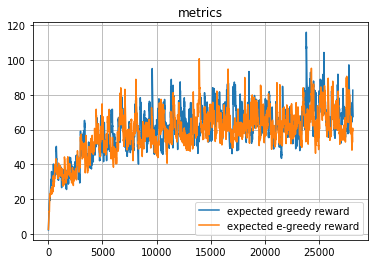

Random session examples


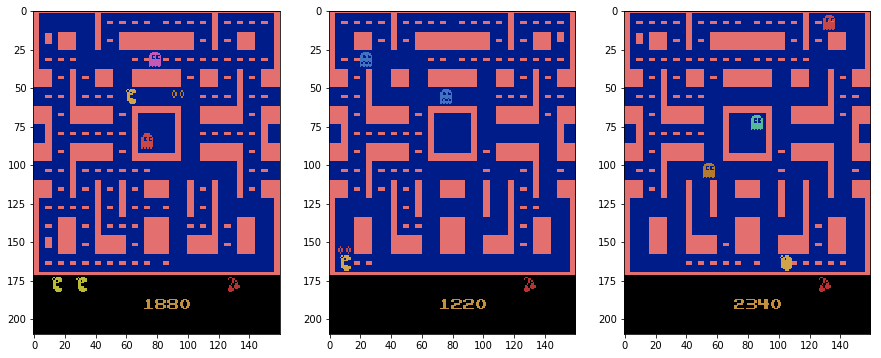

epoch 28110,loss 484.81260, epsilon 0.05000, rewards: ( e-greedy 56.14743, greedy 77.00860) 
rec 471.818 reg 12.995
epoch 28120,loss 6676.90839, epsilon 0.05000, rewards: ( e-greedy 69.28269, greedy 74.55774) 
rec 6663.902 reg 13.007
epoch 28130,loss 308.54462, epsilon 0.05000, rewards: ( e-greedy 66.85442, greedy 73.47697) 
rec 295.505 reg 13.040
epoch 28140,loss 737.02868, epsilon 0.05000, rewards: ( e-greedy 65.04398, greedy 70.12927) 
rec 723.970 reg 13.058
epoch 28150,loss 696.35498, epsilon 0.05000, rewards: ( e-greedy 64.66458, greedy 68.74134) 
rec 683.295 reg 13.060
epoch 28160,loss 770.70574, epsilon 0.05000, rewards: ( e-greedy 63.32312, greedy 66.24221) 
rec 757.644 reg 13.062
epoch 28170,loss 287.77995, epsilon 0.05000, rewards: ( e-greedy 60.61581, greedy 62.36799) 
rec 274.713 reg 13.067
epoch 28180,loss 315.46014, epsilon 0.05000, rewards: ( e-greedy 59.42923, greedy 61.75619) 
rec 302.400 reg 13.061
epoch 28190,loss 649.24200, epsilon 0.05000, rewards: ( e-greedy 58.86

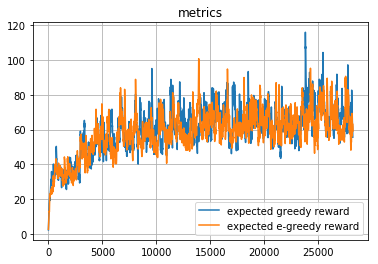

Random session examples


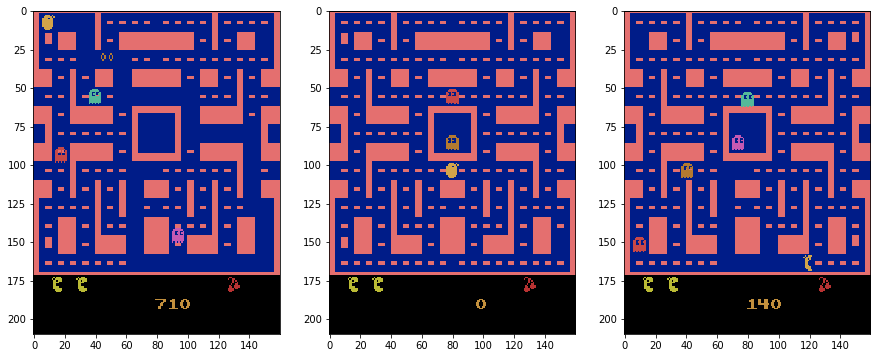

epoch 28210,loss 1146.54279, epsilon 0.05000, rewards: ( e-greedy 62.55266, greedy 57.77651) 
rec 1133.487 reg 13.056
epoch 28220,loss 1578.49933, epsilon 0.05000, rewards: ( e-greedy 69.04739, greedy 56.12386) 
rec 1565.422 reg 13.077
epoch 28230,loss 296.47270, epsilon 0.05000, rewards: ( e-greedy 65.64265, greedy 58.51148) 
rec 283.388 reg 13.085
epoch 28240,loss 1918.86590, epsilon 0.05000, rewards: ( e-greedy 73.45339, greedy 61.16033) 
rec 1905.784 reg 13.081
epoch 28250,loss 892.25297, epsilon 0.05000, rewards: ( e-greedy 70.98305, greedy 57.29429) 
rec 879.176 reg 13.077
epoch 28260,loss 2065.24742, epsilon 0.05000, rewards: ( e-greedy 77.00974, greedy 56.06487) 
rec 2052.182 reg 13.066
epoch 28270,loss 229.73722, epsilon 0.05000, rewards: ( e-greedy 71.18377, greedy 57.08338) 
rec 216.684 reg 13.053
epoch 28280,loss 436.13318, epsilon 0.05000, rewards: ( e-greedy 70.31539, greedy 60.50004) 
rec 423.080 reg 13.053
epoch 28290,loss 364.61447, epsilon 0.05000, rewards: ( e-greedy

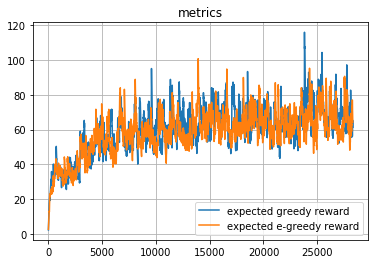

Random session examples


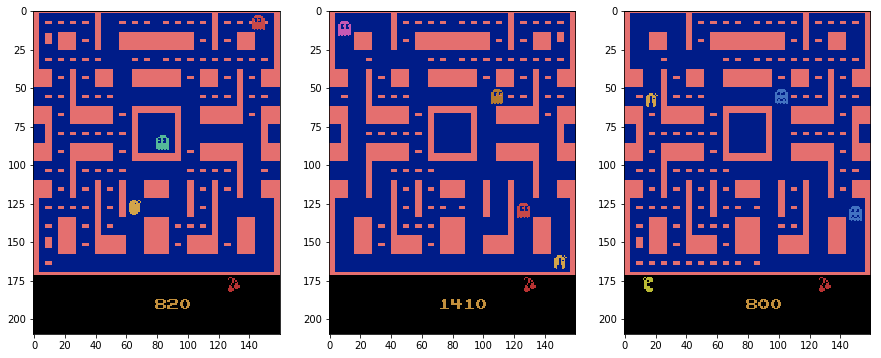

epoch 28310,loss 13663.69688, epsilon 0.05000, rewards: ( e-greedy 77.13742, greedy 61.03828) 
rec 13650.659 reg 13.038
epoch 28320,loss 967.00136, epsilon 0.05000, rewards: ( e-greedy 75.04868, greedy 56.80945) 
rec 953.921 reg 13.080
epoch 28330,loss 885.61176, epsilon 0.05000, rewards: ( e-greedy 74.91881, greedy 63.75351) 
rec 872.493 reg 13.119
epoch 28340,loss 310.55605, epsilon 0.05000, rewards: ( e-greedy 71.05193, greedy 61.87816) 
rec 297.409 reg 13.147
epoch 28350,loss 474.35316, epsilon 0.05000, rewards: ( e-greedy 71.44674, greedy 61.94034) 
rec 461.176 reg 13.177
epoch 28360,loss 413.68141, epsilon 0.05000, rewards: ( e-greedy 67.30206, greedy 59.49631) 
rec 400.452 reg 13.230
epoch 28370,loss 218.87658, epsilon 0.05000, rewards: ( e-greedy 62.94686, greedy 58.04668) 
rec 205.622 reg 13.255
epoch 28380,loss 317.59690, epsilon 0.05000, rewards: ( e-greedy 60.65217, greedy 56.74201) 
rec 304.334 reg 13.263
epoch 28390,loss 4189.30117, epsilon 0.05000, rewards: ( e-greedy 64

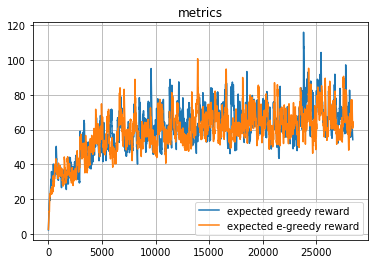

Random session examples


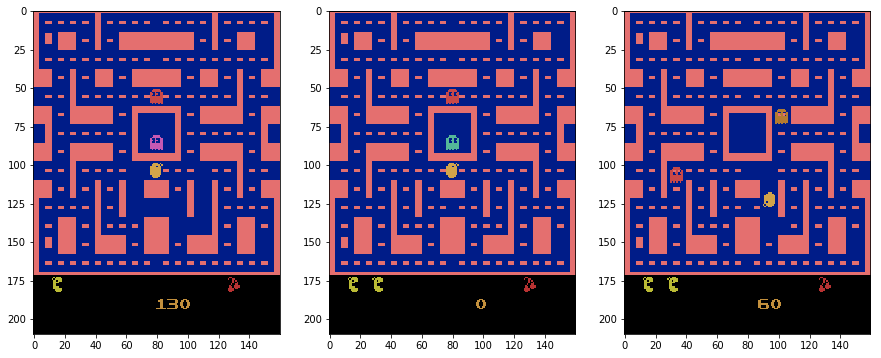

epoch 28410,loss 254.66201, epsilon 0.05000, rewards: ( e-greedy 59.20418, greedy 54.75617) 
rec 241.368 reg 13.294
epoch 28420,loss 587.97093, epsilon 0.05000, rewards: ( e-greedy 57.78376, greedy 60.90556) 
rec 574.665 reg 13.306
epoch 28430,loss 982.97703, epsilon 0.05000, rewards: ( e-greedy 60.13039, greedy 62.69000) 
rec 969.661 reg 13.316
epoch 28440,loss 856.04202, epsilon 0.05000, rewards: ( e-greedy 58.36735, greedy 70.29600) 
rec 842.713 reg 13.329
epoch 28450,loss 962.86035, epsilon 0.05000, rewards: ( e-greedy 59.53061, greedy 65.89140) 
rec 949.522 reg 13.338
epoch 28460,loss 834.56982, epsilon 0.05000, rewards: ( e-greedy 60.57755, greedy 62.30226) 
rec 821.233 reg 13.337
epoch 28470,loss 333.76222, epsilon 0.05000, rewards: ( e-greedy 59.01980, greedy 61.19703) 
rec 320.434 reg 13.328
epoch 28480,loss 226.77599, epsilon 0.05000, rewards: ( e-greedy 56.74282, greedy 61.95233) 
rec 213.445 reg 13.331
epoch 28490,loss 607.28288, epsilon 0.05000, rewards: ( e-greedy 57.9435

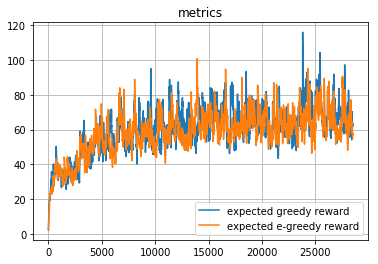

Random session examples


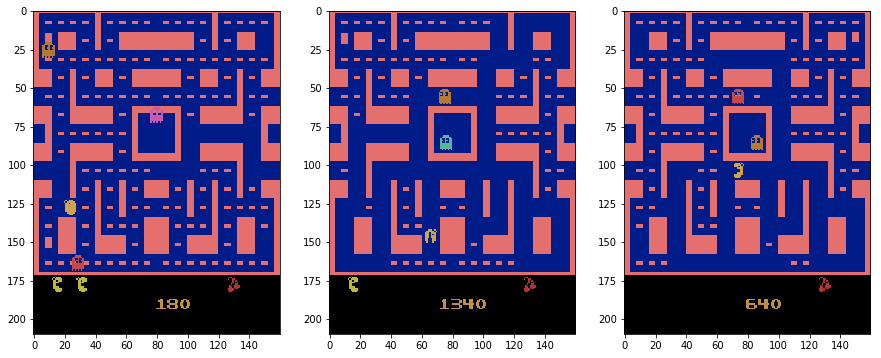

epoch 28510,loss 294.28239, epsilon 0.05000, rewards: ( e-greedy 54.87176, greedy 64.28950) 
rec 280.961 reg 13.321
epoch 28520,loss 826.56644, epsilon 0.05000, rewards: ( e-greedy 53.63459, greedy 65.61055) 
rec 813.247 reg 13.320
epoch 28530,loss 806.60851, epsilon 0.05000, rewards: ( e-greedy 59.64613, greedy 70.42449) 
rec 793.280 reg 13.329
epoch 28540,loss 364.24746, epsilon 0.05000, rewards: ( e-greedy 57.68152, greedy 71.75705) 
rec 350.909 reg 13.338
epoch 28550,loss 2254.33310, epsilon 0.05000, rewards: ( e-greedy 62.91336, greedy 72.70634) 
rec 2240.992 reg 13.341
epoch 28560,loss 488.56968, epsilon 0.05000, rewards: ( e-greedy 62.37203, greedy 74.56071) 
rec 475.230 reg 13.339
epoch 28570,loss 615.30927, epsilon 0.05000, rewards: ( e-greedy 62.63483, greedy 73.60464) 
rec 601.958 reg 13.351
epoch 28580,loss 449.13065, epsilon 0.05000, rewards: ( e-greedy 59.74634, greedy 69.24417) 
rec 435.770 reg 13.361
epoch 28590,loss 227.37686, epsilon 0.05000, rewards: ( e-greedy 58.02

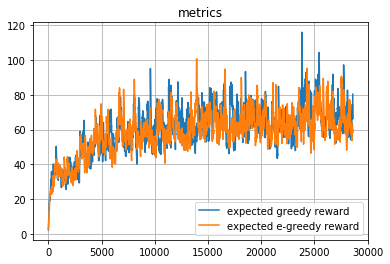

Random session examples


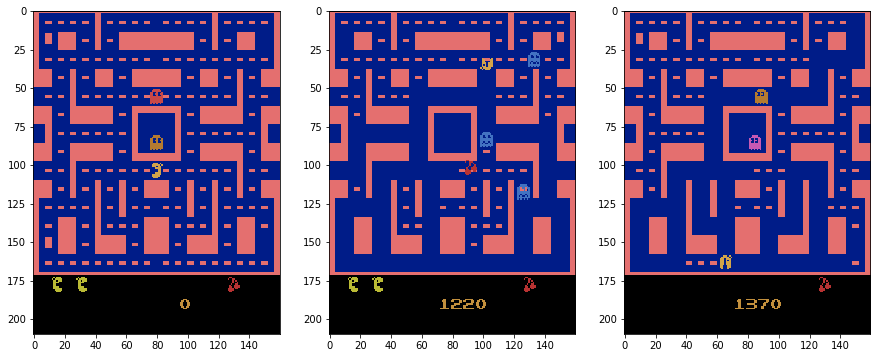

epoch 28610,loss 1368.31044, epsilon 0.05000, rewards: ( e-greedy 63.72258, greedy 81.42900) 
rec 1354.944 reg 13.366
epoch 28620,loss 512.16588, epsilon 0.05000, rewards: ( e-greedy 63.47533, greedy 78.16110) 
rec 498.808 reg 13.358
epoch 28630,loss 403.56954, epsilon 0.05000, rewards: ( e-greedy 61.00279, greedy 75.34499) 
rec 390.215 reg 13.354
epoch 28640,loss 177.98166, epsilon 0.05000, rewards: ( e-greedy 57.27751, greedy 71.93549) 
rec 164.628 reg 13.354
epoch 28650,loss 792.70368, epsilon 0.05000, rewards: ( e-greedy 59.79976, greedy 67.74194) 
rec 779.348 reg 13.355
epoch 28660,loss 414.87555, epsilon 0.05000, rewards: ( e-greedy 59.06979, greedy 72.84275) 
rec 401.525 reg 13.351
epoch 28670,loss 319.51872, epsilon 0.05000, rewards: ( e-greedy 56.91281, greedy 68.18347) 
rec 306.175 reg 13.344
epoch 28680,loss 350.55266, epsilon 0.05000, rewards: ( e-greedy 55.22153, greedy 68.74013) 
rec 337.215 reg 13.338
epoch 28690,loss 371.09308, epsilon 0.05000, rewards: ( e-greedy 54.44

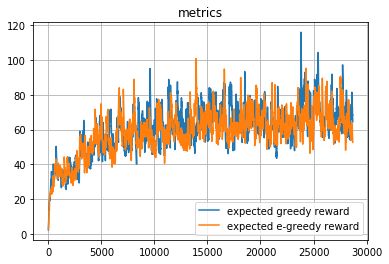

Random session examples


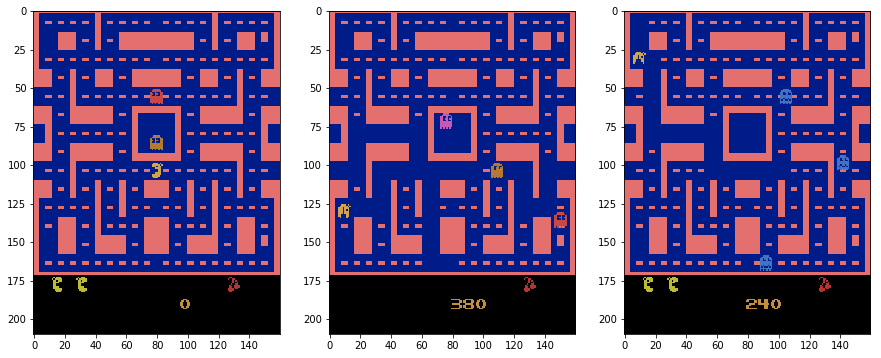

epoch 28710,loss 302.84448, epsilon 0.05000, rewards: ( e-greedy 50.11649, greedy 61.61155) 
rec 289.514 reg 13.331
epoch 28720,loss 9467.64087, epsilon 0.05000, rewards: ( e-greedy 60.22984, greedy 59.82540) 
rec 9454.322 reg 13.319
epoch 28730,loss 275.00680, epsilon 0.05000, rewards: ( e-greedy 57.08186, greedy 55.96786) 
rec 261.682 reg 13.324
epoch 28740,loss 559.85834, epsilon 0.05000, rewards: ( e-greedy 55.87367, greedy 58.49607) 
rec 546.526 reg 13.332
epoch 28750,loss 520.33680, epsilon 0.05000, rewards: ( e-greedy 55.78631, greedy 56.27146) 
rec 507.007 reg 13.330
epoch 28760,loss 1037.11334, epsilon 0.05000, rewards: ( e-greedy 58.20768, greedy 61.89432) 
rec 1023.789 reg 13.324
epoch 28770,loss 342.23545, epsilon 0.05000, rewards: ( e-greedy 57.38691, greedy 60.95489) 
rec 328.915 reg 13.321
epoch 28780,loss 308.86697, epsilon 0.05000, rewards: ( e-greedy 54.14822, greedy 57.48440) 
rec 295.546 reg 13.321
epoch 28790,loss 662.14014, epsilon 0.05000, rewards: ( e-greedy 52.

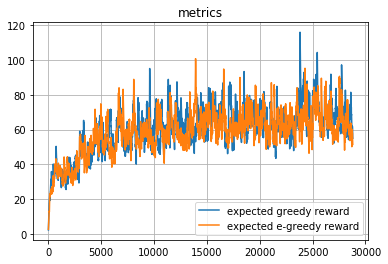

Random session examples


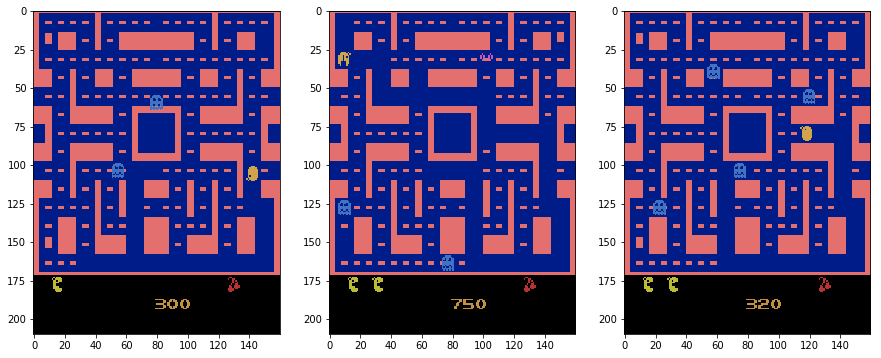

epoch 28810,loss 381.57543, epsilon 0.05000, rewards: ( e-greedy 51.68905, greedy 55.74988) 
rec 368.274 reg 13.302
epoch 28820,loss 257.80857, epsilon 0.05000, rewards: ( e-greedy 51.14515, greedy 53.17489) 
rec 244.506 reg 13.303
epoch 28830,loss 253.74189, epsilon 0.05000, rewards: ( e-greedy 47.65563, greedy 57.23240) 
rec 240.444 reg 13.298
epoch 28840,loss 4477.43455, epsilon 0.05000, rewards: ( e-greedy 61.39007, greedy 60.13416) 
rec 4464.133 reg 13.301
epoch 28850,loss 769.39273, epsilon 0.05000, rewards: ( e-greedy 60.87606, greedy 58.24574) 
rec 756.067 reg 13.326
epoch 28860,loss 3394.32582, epsilon 0.05000, rewards: ( e-greedy 63.78845, greedy 57.17117) 
rec 3380.977 reg 13.349
epoch 28870,loss 488.75191, epsilon 0.05000, rewards: ( e-greedy 62.03461, greedy 60.45405) 
rec 475.385 reg 13.367
epoch 28880,loss 2233.07510, epsilon 0.05000, rewards: ( e-greedy 68.83115, greedy 66.78365) 
rec 2219.703 reg 13.372
epoch 28890,loss 815.75860, epsilon 0.05000, rewards: ( e-greedy 7

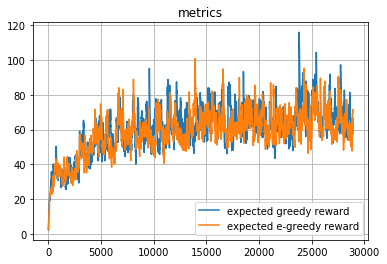

Random session examples


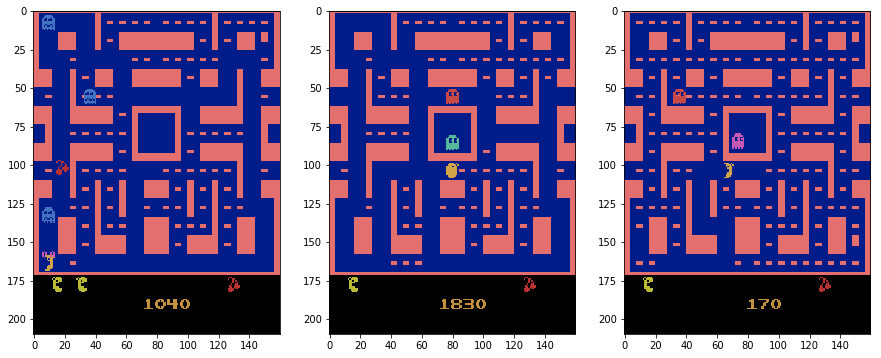

epoch 28910,loss 596.99700, epsilon 0.05000, rewards: ( e-greedy 70.66166, greedy 58.68778) 
rec 583.621 reg 13.376
epoch 28920,loss 265.12943, epsilon 0.05000, rewards: ( e-greedy 67.34549, greedy 57.44400) 
rec 251.768 reg 13.362
epoch 28930,loss 222.70710, epsilon 0.05000, rewards: ( e-greedy 65.61094, greedy 58.44960) 
rec 209.361 reg 13.346
epoch 28940,loss 1930.56528, epsilon 0.05000, rewards: ( e-greedy 74.54985, greedy 58.60464) 
rec 1917.232 reg 13.334
epoch 28950,loss 244.88100, epsilon 0.05000, rewards: ( e-greedy 69.34486, greedy 55.99418) 
rec 231.555 reg 13.326
epoch 28960,loss 5438.50555, epsilon 0.05000, rewards: ( e-greedy 76.53538, greedy 77.01976) 
rec 5425.185 reg 13.321
epoch 28970,loss 322.87029, epsilon 0.05000, rewards: ( e-greedy 74.88184, greedy 75.94278) 
rec 309.551 reg 13.319
epoch 28980,loss 3388.91391, epsilon 0.05000, rewards: ( e-greedy 84.01866, greedy 72.22350) 
rec 3375.605 reg 13.309
epoch 28990,loss 1079.62756, epsilon 0.05000, rewards: ( e-greedy 

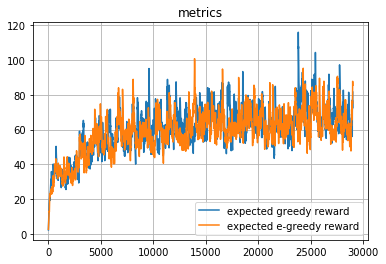

Random session examples


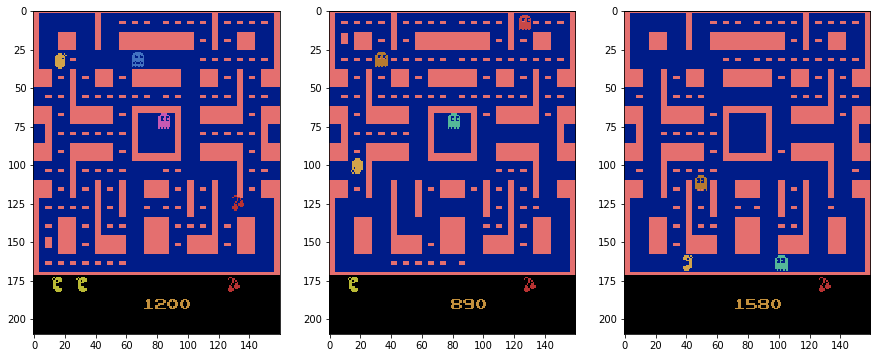

[2017-05-23 14:24:06,593] Making new env: MsPacman-v0
[2017-05-23 14:24:06,757] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-23 14:24:06,767] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.32.14344.video000000.mp4
[2017-05-23 14:24:08,877] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.32.14344.video000001.mp4


Episode finished after 925 timesteps, rw = 440.0
Episode finished after 1038 timesteps, rw = 240.0
Episode finished after 636 timesteps, rw = 190.0
Episode finished after 936 timesteps, rw = 330.0
Episode finished after 1044 timesteps, rw = 240.0
Episode finished after 849 timesteps, rw = 520.0
Episode finished after 834 timesteps, rw = 440.0


[2017-05-23 14:24:21,406] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.32.14344.video000008.mp4


Episode finished after 948 timesteps, rw = 440.0
Episode finished after 944 timesteps, rw = 1640.0
Episode finished after 876 timesteps, rw = 240.0
Episode finished after 886 timesteps, rw = 320.0
Episode finished after 812 timesteps, rw = 200.0
Episode finished after 950 timesteps, rw = 240.0
Episode finished after 867 timesteps, rw = 240.0
Episode finished after 876 timesteps, rw = 330.0
Episode finished after 899 timesteps, rw = 440.0
Episode finished after 774 timesteps, rw = 250.0
Episode finished after 806 timesteps, rw = 440.0
Episode finished after 948 timesteps, rw = 450.0


[2017-05-23 14:24:42,199] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/fat_videos')


Episode finished after 963 timesteps, rw = 440.0
Mean 403.5, Var 90732.75
epoch 29010,loss 382.81698, epsilon 0.05000, rewards: ( e-greedy 82.42085, greedy 78.64593) 
rec 369.527 reg 13.290
epoch 29020,loss 298.25700, epsilon 0.05000, rewards: ( e-greedy 80.30376, greedy 77.90634) 
rec 284.969 reg 13.288
epoch 29030,loss 323.66459, epsilon 0.05000, rewards: ( e-greedy 76.77339, greedy 75.99071) 
rec 310.383 reg 13.282
epoch 29040,loss 238.36241, epsilon 0.05000, rewards: ( e-greedy 72.34605, greedy 74.26664) 
rec 225.095 reg 13.268
epoch 29050,loss 1305.50837, epsilon 0.05000, rewards: ( e-greedy 71.48644, greedy 72.33997) 
rec 1292.251 reg 13.258
epoch 29060,loss 413.69706, epsilon 0.05000, rewards: ( e-greedy 69.96280, greedy 69.60598) 
rec 400.447 reg 13.250
epoch 29070,loss 3081.10709, epsilon 0.05000, rewards: ( e-greedy 68.46652, greedy 64.14538) 
rec 3067.866 reg 13.241
epoch 29080,loss 1550.29821, epsilon 0.05000, rewards: ( e-greedy 74.86987, greedy 67.23084) 
rec 1537.061 reg

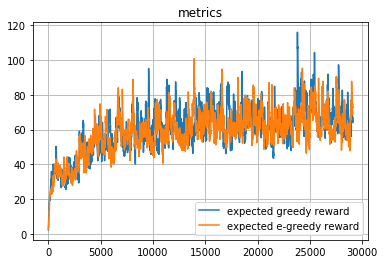

Random session examples


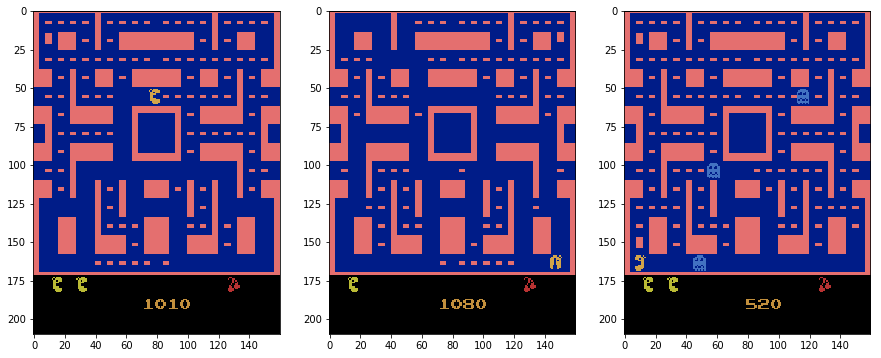

epoch 29110,loss 524.15070, epsilon 0.05000, rewards: ( e-greedy 69.36888, greedy 63.50378) 
rec 510.889 reg 13.261
epoch 29120,loss 962.25046, epsilon 0.05000, rewards: ( e-greedy 70.55700, greedy 65.02840) 
rec 948.987 reg 13.263
epoch 29130,loss 496.41651, epsilon 0.05000, rewards: ( e-greedy 66.12630, greedy 60.52556) 
rec 483.149 reg 13.267
epoch 29140,loss 1223.90879, epsilon 0.05000, rewards: ( e-greedy 67.01367, greedy 60.72301) 
rec 1210.640 reg 13.269
epoch 29150,loss 372.81002, epsilon 0.05000, rewards: ( e-greedy 63.93730, greedy 58.27571) 
rec 359.545 reg 13.265
epoch 29160,loss 635.72272, epsilon 0.05000, rewards: ( e-greedy 61.54357, greedy 55.32314) 
rec 622.463 reg 13.260
epoch 29170,loss 837.11675, epsilon 0.05000, rewards: ( e-greedy 60.63921, greedy 51.66582) 
rec 823.863 reg 13.253
epoch 29180,loss 383.37923, epsilon 0.05000, rewards: ( e-greedy 59.95029, greedy 55.87424) 
rec 370.135 reg 13.244
epoch 29190,loss 2826.23866, epsilon 0.05000, rewards: ( e-greedy 63.5

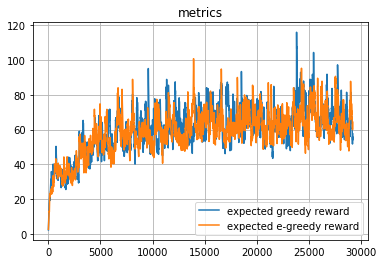

Random session examples


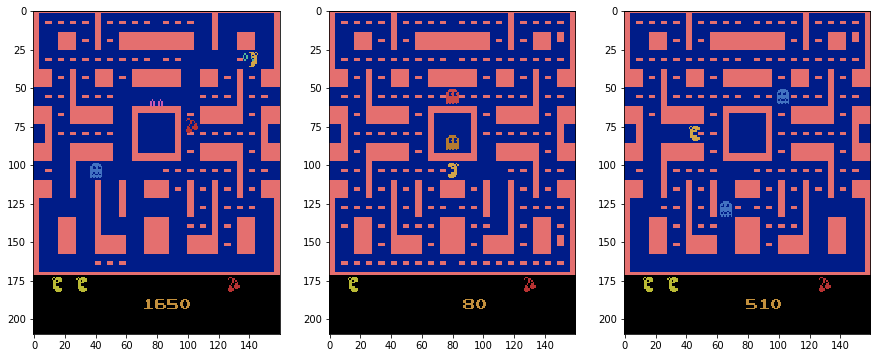

epoch 29210,loss 349.17227, epsilon 0.05000, rewards: ( e-greedy 60.42501, greedy 56.89357) 
rec 335.918 reg 13.254
epoch 29220,loss 319.01775, epsilon 0.05000, rewards: ( e-greedy 56.13251, greedy 58.20421) 
rec 305.767 reg 13.251
epoch 29230,loss 577.45173, epsilon 0.05000, rewards: ( e-greedy 55.89426, greedy 71.88379) 
rec 564.210 reg 13.242
epoch 29240,loss 206.21090, epsilon 0.05000, rewards: ( e-greedy 52.80483, greedy 70.07041) 
rec 192.975 reg 13.236
epoch 29250,loss 813.53065, epsilon 0.05000, rewards: ( e-greedy 54.77435, greedy 70.06337) 
rec 800.304 reg 13.227
epoch 29260,loss 329.29593, epsilon 0.05000, rewards: ( e-greedy 54.92192, greedy 68.05703) 
rec 316.077 reg 13.219
epoch 29270,loss 9004.87579, epsilon 0.05000, rewards: ( e-greedy 69.92972, greedy 97.75133) 
rec 8991.666 reg 13.210
epoch 29280,loss 292.01362, epsilon 0.05000, rewards: ( e-greedy 68.18675, greedy 96.60120) 
rec 278.811 reg 13.203
epoch 29290,loss 641.14804, epsilon 0.05000, rewards: ( e-greedy 64.36

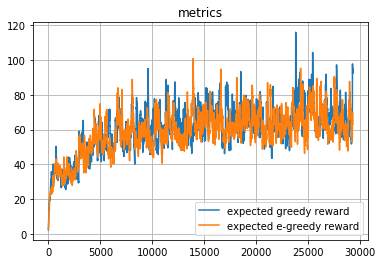

Random session examples


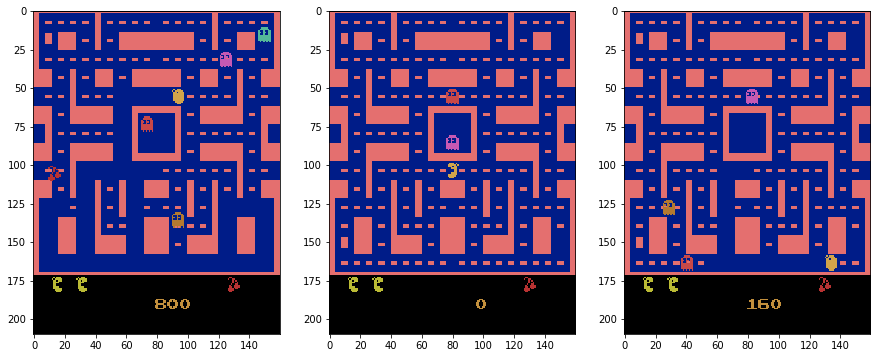

epoch 29310,loss 462.53775, epsilon 0.05000, rewards: ( e-greedy 62.12564, greedy 93.48727) 
rec 449.341 reg 13.196
epoch 29320,loss 491.21253, epsilon 0.05000, rewards: ( e-greedy 62.41308, greedy 88.38855) 
rec 478.024 reg 13.189
epoch 29330,loss 3226.66176, epsilon 0.05000, rewards: ( e-greedy 69.92177, greedy 89.79969) 
rec 3213.457 reg 13.204
epoch 29340,loss 606.32498, epsilon 0.05000, rewards: ( e-greedy 71.05459, greedy 88.81972) 
rec 593.110 reg 13.215
epoch 29350,loss 980.55028, epsilon 0.05000, rewards: ( e-greedy 68.07413, greedy 85.31275) 
rec 967.332 reg 13.218
epoch 29360,loss 3866.81773, epsilon 0.05000, rewards: ( e-greedy 76.26672, greedy 79.40648) 
rec 3853.594 reg 13.224
epoch 29370,loss 470.67997, epsilon 0.05000, rewards: ( e-greedy 75.64005, greedy 78.34083) 
rec 457.447 reg 13.233
epoch 29380,loss 1355.61349, epsilon 0.05000, rewards: ( e-greedy 75.70104, greedy 74.63174) 
rec 1342.373 reg 13.241
epoch 29390,loss 1626.73133, epsilon 0.05000, rewards: ( e-greedy 

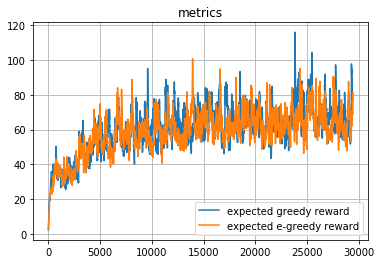

Random session examples


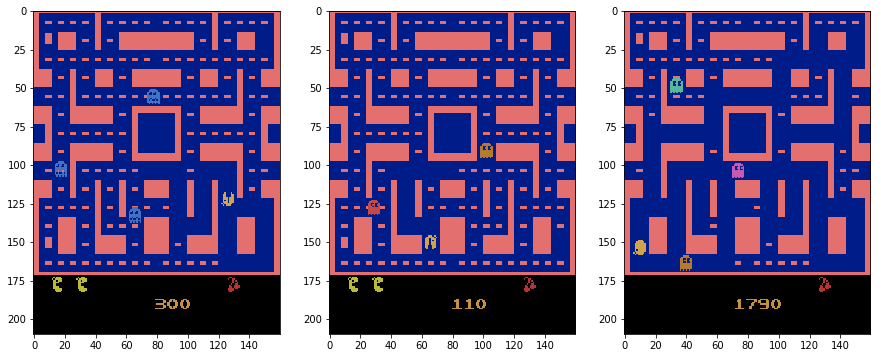

epoch 29410,loss 1775.08043, epsilon 0.05000, rewards: ( e-greedy 79.96731, greedy 65.59029) 
rec 1761.851 reg 13.230
epoch 29420,loss 502.31664, epsilon 0.05000, rewards: ( e-greedy 78.84558, greedy 68.28126) 
rec 489.082 reg 13.235
epoch 29430,loss 556.22416, epsilon 0.05000, rewards: ( e-greedy 78.33602, greedy 64.82814) 
rec 542.988 reg 13.236
epoch 29440,loss 689.48851, epsilon 0.05000, rewards: ( e-greedy 73.75242, greedy 62.34532) 
rec 676.259 reg 13.230
epoch 29450,loss 2241.12753, epsilon 0.05000, rewards: ( e-greedy 81.62718, greedy 59.36079) 
rec 2227.904 reg 13.223
epoch 29460,loss 5328.03633, epsilon 0.05000, rewards: ( e-greedy 94.83946, greedy 66.79971) 
rec 5314.817 reg 13.219
epoch 29470,loss 494.79904, epsilon 0.05000, rewards: ( e-greedy 88.85551, greedy 63.36974) 
rec 481.572 reg 13.227
epoch 29480,loss 336.96730, epsilon 0.05000, rewards: ( e-greedy 85.34496, greedy 60.90777) 
rec 323.746 reg 13.221
epoch 29490,loss 530.77405, epsilon 0.05000, rewards: ( e-greedy 8

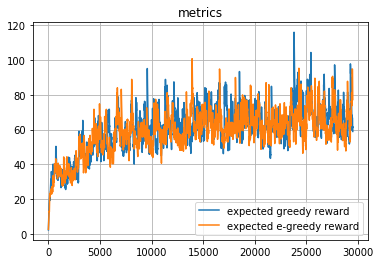

Random session examples


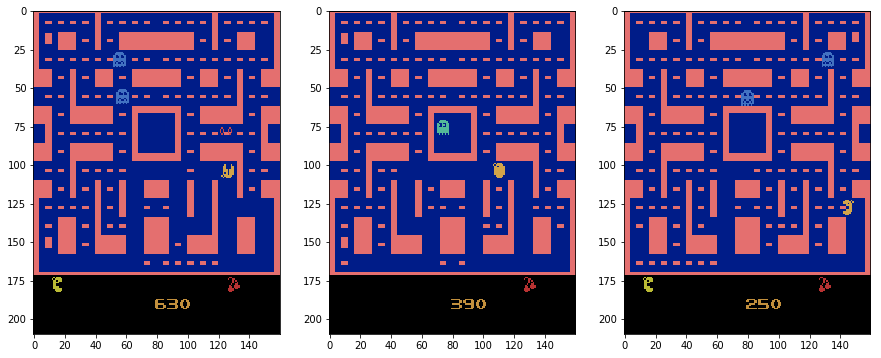

epoch 29510,loss 8088.82261, epsilon 0.05000, rewards: ( e-greedy 91.01773, greedy 61.88301) 
rec 8075.587 reg 13.236
epoch 29520,loss 639.73978, epsilon 0.05000, rewards: ( e-greedy 92.41595, greedy 71.81971) 
rec 626.495 reg 13.245
epoch 29530,loss 286.21598, epsilon 0.05000, rewards: ( e-greedy 84.67436, greedy 66.51274) 
rec 272.966 reg 13.250
epoch 29540,loss 1231.42967, epsilon 0.05000, rewards: ( e-greedy 82.70692, greedy 64.73647) 
rec 1218.184 reg 13.245
epoch 29550,loss 381.57773, epsilon 0.05000, rewards: ( e-greedy 81.31123, greedy 66.88782) 
rec 368.336 reg 13.242
epoch 29560,loss 493.51687, epsilon 0.05000, rewards: ( e-greedy 79.18011, greedy 73.69904) 
rec 480.275 reg 13.242
epoch 29570,loss 517.73935, epsilon 0.05000, rewards: ( e-greedy 73.51210, greedy 76.20413) 
rec 504.497 reg 13.243
epoch 29580,loss 1215.08662, epsilon 0.05000, rewards: ( e-greedy 80.41089, greedy 80.45872) 
rec 1201.846 reg 13.241
epoch 29590,loss 509.26546, epsilon 0.05000, rewards: ( e-greedy 7

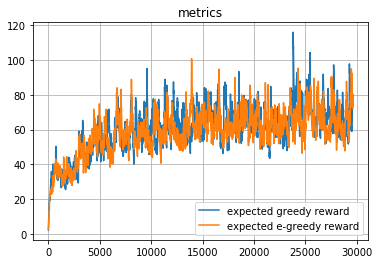

Random session examples


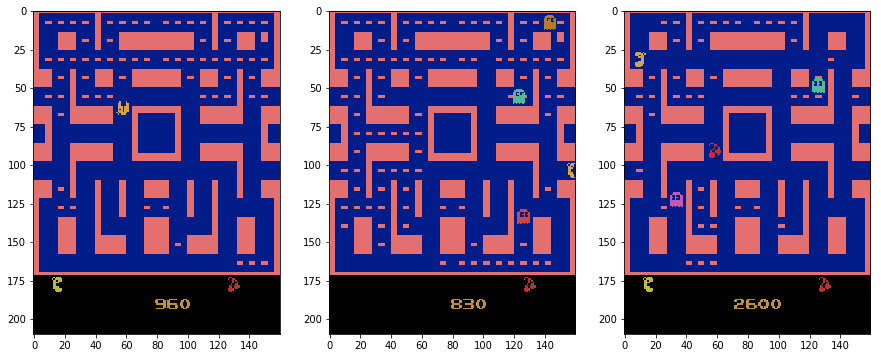

epoch 29610,loss 1318.85599, epsilon 0.05000, rewards: ( e-greedy 72.74829, greedy 81.86691) 
rec 1305.633 reg 13.223
epoch 29620,loss 301.44455, epsilon 0.05000, rewards: ( e-greedy 69.22346, greedy 80.68022) 
rec 288.217 reg 13.228
epoch 29630,loss 277.69230, epsilon 0.05000, rewards: ( e-greedy 66.55111, greedy 80.48719) 
rec 264.456 reg 13.237
epoch 29640,loss 226.42724, epsilon 0.05000, rewards: ( e-greedy 63.89600, greedy 75.56348) 
rec 213.187 reg 13.240
epoch 29650,loss 307.97261, epsilon 0.05000, rewards: ( e-greedy 63.25640, greedy 73.00713) 
rec 294.729 reg 13.244
epoch 29660,loss 1512.02177, epsilon 0.05000, rewards: ( e-greedy 64.43076, greedy 73.70641) 
rec 1498.776 reg 13.246
epoch 29670,loss 177.25637, epsilon 0.05000, rewards: ( e-greedy 61.48768, greedy 73.58577) 
rec 164.014 reg 13.243
epoch 29680,loss 1043.08480, epsilon 0.05000, rewards: ( e-greedy 64.83892, greedy 78.72720) 
rec 1029.845 reg 13.239
epoch 29690,loss 321.76767, epsilon 0.05000, rewards: ( e-greedy 6

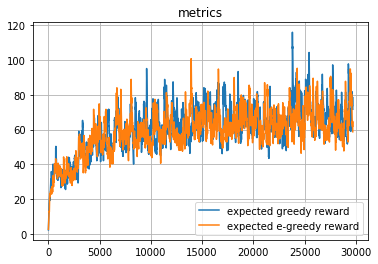

Random session examples


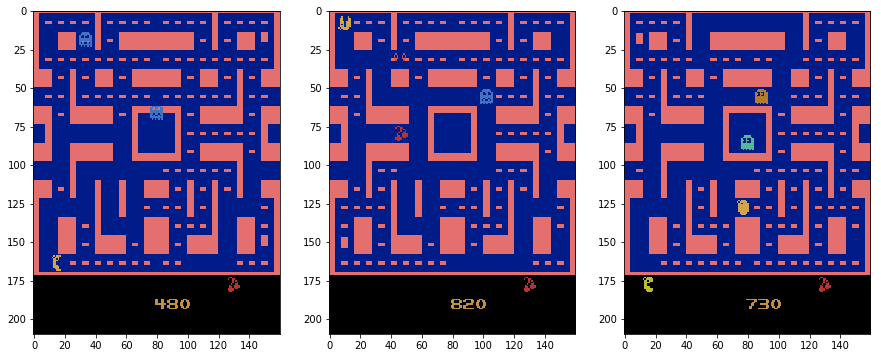

epoch 29710,loss 739.59672, epsilon 0.05000, rewards: ( e-greedy 58.32507, greedy 71.24088) 
rec 726.326 reg 13.270
epoch 29720,loss 303.93077, epsilon 0.05000, rewards: ( e-greedy 55.61756, greedy 67.86679) 
rec 290.658 reg 13.273
epoch 29730,loss 2275.27108, epsilon 0.05000, rewards: ( e-greedy 57.30581, greedy 68.70511) 
rec 2261.989 reg 13.283
epoch 29740,loss 211.39980, epsilon 0.05000, rewards: ( e-greedy 55.20023, greedy 65.45960) 
rec 198.104 reg 13.296
epoch 29750,loss 240.79905, epsilon 0.05000, rewards: ( e-greedy 52.18020, greedy 64.16364) 
rec 227.500 reg 13.299
epoch 29760,loss 352.64802, epsilon 0.05000, rewards: ( e-greedy 49.58718, greedy 62.24727) 
rec 339.357 reg 13.291
epoch 29770,loss 444.63896, epsilon 0.05000, rewards: ( e-greedy 52.12846, greedy 63.52255) 
rec 431.346 reg 13.293
epoch 29780,loss 501.53096, epsilon 0.05000, rewards: ( e-greedy 52.16562, greedy 61.42029) 
rec 488.220 reg 13.311
epoch 29790,loss 367.31433, epsilon 0.05000, rewards: ( e-greedy 50.44

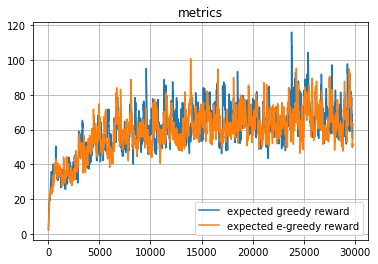

Random session examples


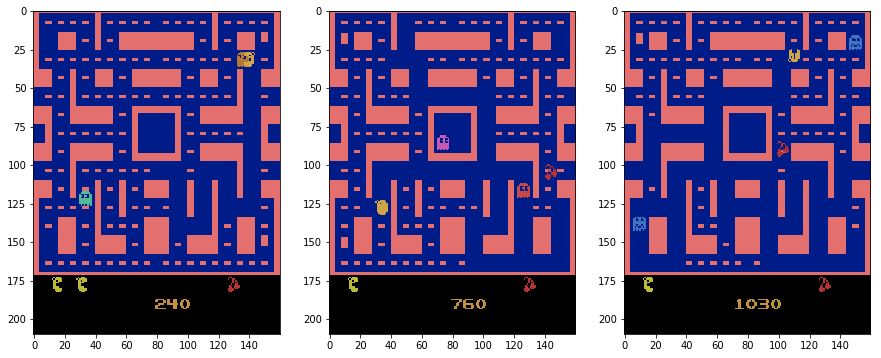

epoch 29810,loss 517.94350, epsilon 0.05000, rewards: ( e-greedy 50.92624, greedy 56.96914) 
rec 504.644 reg 13.300
epoch 29820,loss 9848.94865, epsilon 0.05000, rewards: ( e-greedy 60.33361, greedy 55.27223) 
rec 9835.648 reg 13.300
epoch 29830,loss 1290.06536, epsilon 0.05000, rewards: ( e-greedy 62.42525, greedy 55.99501) 
rec 1276.751 reg 13.315
epoch 29840,loss 315.92704, epsilon 0.05000, rewards: ( e-greedy 59.80773, greedy 54.14551) 
rec 302.595 reg 13.332
epoch 29850,loss 538.78808, epsilon 0.05000, rewards: ( e-greedy 58.70195, greedy 55.10595) 
rec 525.428 reg 13.360
epoch 29860,loss 983.52793, epsilon 0.05000, rewards: ( e-greedy 62.33176, greedy 55.34536) 
rec 970.139 reg 13.389
epoch 29870,loss 489.51131, epsilon 0.05000, rewards: ( e-greedy 60.22358, greedy 55.93582) 
rec 476.101 reg 13.410
epoch 29880,loss 1099.90487, epsilon 0.05000, rewards: ( e-greedy 61.95122, greedy 55.96724) 
rec 1086.447 reg 13.458
epoch 29890,loss 648.05880, epsilon 0.05000, rewards: ( e-greedy 5

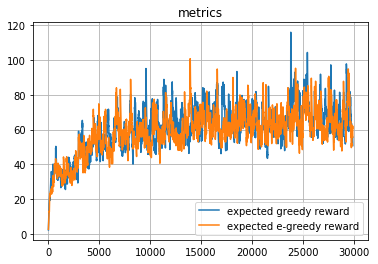

Random session examples


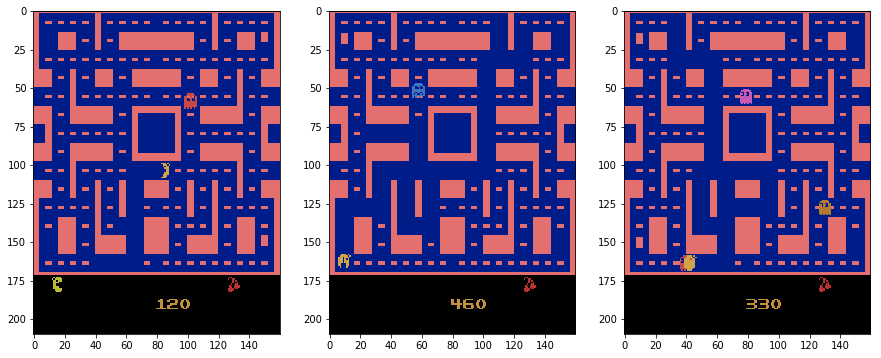

epoch 29910,loss 7491.94255, epsilon 0.05000, rewards: ( e-greedy 65.41994, greedy 53.79637) 
rec 7478.322 reg 13.620
epoch 29920,loss 2073.05848, epsilon 0.05000, rewards: ( e-greedy 68.87795, greedy 52.66673) 
rec 2059.393 reg 13.666
epoch 29930,loss 1237.25617, epsilon 0.05000, rewards: ( e-greedy 66.36515, greedy 48.77506) 
rec 1223.565 reg 13.691
epoch 29940,loss 277.69393, epsilon 0.05000, rewards: ( e-greedy 65.10364, greedy 50.64755) 
rec 263.993 reg 13.701
epoch 29950,loss 206.23116, epsilon 0.05000, rewards: ( e-greedy 62.59327, greedy 50.45780) 
rec 192.526 reg 13.705
epoch 29960,loss 244.62844, epsilon 0.05000, rewards: ( e-greedy 58.33395, greedy 46.28702) 
rec 230.925 reg 13.704
epoch 29970,loss 230.07257, epsilon 0.05000, rewards: ( e-greedy 54.12555, greedy 45.53332) 
rec 216.365 reg 13.707
epoch 29980,loss 218.56538, epsilon 0.05000, rewards: ( e-greedy 50.58800, greedy 42.22998) 
rec 204.849 reg 13.716
epoch 29990,loss 556.83509, epsilon 0.05000, rewards: ( e-greedy 5

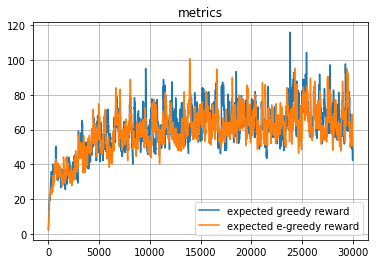

Random session examples


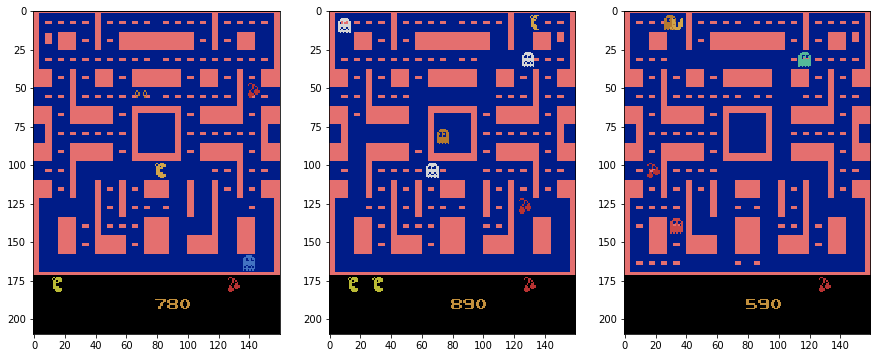

[2017-05-23 14:37:01,642] Making new env: MsPacman-v0
[2017-05-23 14:37:01,804] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-23 14:37:01,813] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.33.14344.video000000.mp4
[2017-05-23 14:37:03,872] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.33.14344.video000001.mp4


Episode finished after 885 timesteps, rw = 240.0
Episode finished after 882 timesteps, rw = 240.0
Episode finished after 1206 timesteps, rw = 320.0
Episode finished after 951 timesteps, rw = 450.0
Episode finished after 995 timesteps, rw = 470.0
Episode finished after 844 timesteps, rw = 440.0
Episode finished after 882 timesteps, rw = 450.0


[2017-05-23 14:37:16,976] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.33.14344.video000008.mp4


Episode finished after 863 timesteps, rw = 440.0
Episode finished after 951 timesteps, rw = 450.0
Episode finished after 695 timesteps, rw = 110.0
Episode finished after 1157 timesteps, rw = 320.0
Episode finished after 871 timesteps, rw = 440.0
Episode finished after 954 timesteps, rw = 320.0
Episode finished after 863 timesteps, rw = 240.0
Episode finished after 880 timesteps, rw = 320.0
Episode finished after 1082 timesteps, rw = 440.0
Episode finished after 773 timesteps, rw = 520.0
Episode finished after 654 timesteps, rw = 180.0
Episode finished after 858 timesteps, rw = 920.0


[2017-05-23 14:37:37,769] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/fat_videos')


Episode finished after 892 timesteps, rw = 240.0
Mean 377.5, Var 27698.75


[2017-05-23 14:37:43,452] VideoRecorder encoder exited with status 1
[2017-05-23 14:37:43,454] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/fat_videos')


KeyboardInterrupt: 

In [44]:
%%time

n_epochs = 25000

for i in range(n_epochs):    
    #train
    update_pool(env,pool,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    ##record current learning progress and show learning curves
    if epoch_counter%10 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_pool(env,pool,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,pool,replay_seq_len)

        print("epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy))
        print("rec %.3f reg %.3f"%(q_loss,l2_penalty))

    if epoch_counter %100 ==0:
        print("Learning curves:")
        score_log.plot()


        print("Random session examples")
        display_sessions()
    
    #run several sessions of game, record videos and save obtained results
    if epoch_counter %1000 ==0:
        
        save_path = 'fat_videos/MSPacman-v0_' + str(epoch_counter)

        subm_env = gym.make(GAME_TITLE)
        subm_env = gym.wrappers.Monitor(subm_env, 'fat_videos/', force=True)

        rws = []

        for i_episode in xrange(20):

            #initial observation
            observation = subm_env.reset()
            #initial memory
            prev_memories = "zeros"

            s_reward =0.
            t = 0
            while True:

                action,new_memories = step([observation],prev_memories,batch_size=1)
                observation, reward, done, info = subm_env.step(action[0])

                s_reward += reward

                prev_memories = new_memories
                if done:
                    print("Episode finished after {} timesteps, rw = {}".format(t+1,s_reward))
                    rws.append(s_reward)
                    break
                t+=1

        subm_env.close()

        rws = np.array(rws)
        print("Mean {}, Var {}".format(np.mean(rws), np.var(rws)))
        np.savez(open('rws4hist_fat_'+str(epoch_counter)+'.npz', 'wb'), rws=rws)
        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

### Record videos

In [76]:
save_path = 'videos/MSPacman-v0_' + str(epoch_counter-1)

subm_env = gym.make(GAME_TITLE)
subm_env = gym.wrappers.Monitor(subm_env, 'Untitled Folder/')

rws = []

for i_episode in xrange(220):

    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = "zeros"

    s_reward =0.
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories,batch_size=1)
        observation, reward, done, info = subm_env.step(action[0])

        s_reward += reward

        prev_memories = new_memories
        if done:
            print("Episode finished after {} timesteps, rw = {}".format(t+1,s_reward))
            rws.append(s_reward)
            break
        t+=1

subm_env.close()

rws = np.array(rws)
np.savez(open('rws5hist_'+str(epoch_counter-1)+'.npz', 'wb'), rws=rws)

[2017-05-23 14:57:42,722] Making new env: MsPacman-v0
[2017-05-23 14:57:42,990] Starting new video recorder writing to /home/vishimtsev/folder/Untitled Folder/openaigym.video.35.14344.video000000.mp4
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()
[2017-05-23 14:57:45,427] Starting new video recorder writing to /home/vishimtsev/folder/Untitled Folder/openaigym.video.35.14344.video000001.mp4


Episode finished after 994 timesteps, rw = 450.0
Episode finished after 1333 timesteps, rw = 240.0
Episode finished after 948 timesteps, rw = 450.0
Episode finished after 872 timesteps, rw = 450.0
Episode finished after 816 timesteps, rw = 240.0
Episode finished after 859 timesteps, rw = 240.0
Episode finished after 696 timesteps, rw = 90.0


[2017-05-23 14:57:58,834] Starting new video recorder writing to /home/vishimtsev/folder/Untitled Folder/openaigym.video.35.14344.video000008.mp4


Episode finished after 1103 timesteps, rw = 440.0
Episode finished after 1033 timesteps, rw = 240.0
Episode finished after 968 timesteps, rw = 240.0
Episode finished after 887 timesteps, rw = 440.0
Episode finished after 816 timesteps, rw = 520.0
Episode finished after 916 timesteps, rw = 440.0
Episode finished after 988 timesteps, rw = 240.0
Episode finished after 811 timesteps, rw = 250.0
Episode finished after 962 timesteps, rw = 440.0
Episode finished after 840 timesteps, rw = 440.0
Episode finished after 891 timesteps, rw = 440.0
Episode finished after 820 timesteps, rw = 240.0
Episode finished after 1049 timesteps, rw = 240.0
Episode finished after 895 timesteps, rw = 440.0
Episode finished after 899 timesteps, rw = 450.0
Episode finished after 835 timesteps, rw = 460.0
Episode finished after 967 timesteps, rw = 320.0
Episode finished after 891 timesteps, rw = 890.0
Episode finished after 700 timesteps, rw = 100.0


[2017-05-23 14:58:32,261] Starting new video recorder writing to /home/vishimtsev/folder/Untitled Folder/openaigym.video.35.14344.video000027.mp4


Episode finished after 865 timesteps, rw = 440.0
Episode finished after 956 timesteps, rw = 1640.0
Episode finished after 687 timesteps, rw = 70.0
Episode finished after 1026 timesteps, rw = 250.0
Episode finished after 860 timesteps, rw = 240.0
Episode finished after 975 timesteps, rw = 240.0
Episode finished after 794 timesteps, rw = 490.0
Episode finished after 881 timesteps, rw = 240.0
Episode finished after 856 timesteps, rw = 240.0
Episode finished after 1117 timesteps, rw = 240.0
Episode finished after 1097 timesteps, rw = 240.0
Episode finished after 997 timesteps, rw = 850.0
Episode finished after 918 timesteps, rw = 440.0
Episode finished after 760 timesteps, rw = 240.0
Episode finished after 858 timesteps, rw = 450.0
Episode finished after 878 timesteps, rw = 440.0
Episode finished after 960 timesteps, rw = 440.0
Episode finished after 930 timesteps, rw = 440.0
Episode finished after 758 timesteps, rw = 200.0
Episode finished after 1005 timesteps, rw = 440.0
Episode finished

[2017-05-23 14:59:37,297] Starting new video recorder writing to /home/vishimtsev/folder/Untitled Folder/openaigym.video.35.14344.video000064.mp4


Episode finished after 970 timesteps, rw = 450.0
Episode finished after 1072 timesteps, rw = 250.0
Episode finished after 909 timesteps, rw = 240.0
Episode finished after 983 timesteps, rw = 840.0
Episode finished after 861 timesteps, rw = 840.0
Episode finished after 1155 timesteps, rw = 490.0
Episode finished after 813 timesteps, rw = 240.0
Episode finished after 965 timesteps, rw = 450.0
Episode finished after 790 timesteps, rw = 890.0
Episode finished after 981 timesteps, rw = 840.0
Episode finished after 980 timesteps, rw = 440.0
Episode finished after 967 timesteps, rw = 450.0
Episode finished after 873 timesteps, rw = 240.0
Episode finished after 963 timesteps, rw = 250.0
Episode finished after 847 timesteps, rw = 240.0
Episode finished after 957 timesteps, rw = 320.0
Episode finished after 973 timesteps, rw = 240.0
Episode finished after 640 timesteps, rw = 140.0
Episode finished after 891 timesteps, rw = 250.0
Episode finished after 915 timesteps, rw = 450.0
Episode finished a

[2017-05-23 15:01:26,096] Starting new video recorder writing to /home/vishimtsev/folder/Untitled Folder/openaigym.video.35.14344.video000125.mp4


Episode finished after 826 timesteps, rw = 240.0
Episode finished after 975 timesteps, rw = 850.0
Episode finished after 832 timesteps, rw = 240.0
Episode finished after 886 timesteps, rw = 850.0
Episode finished after 636 timesteps, rw = 130.0
Episode finished after 689 timesteps, rw = 100.0
Episode finished after 927 timesteps, rw = 240.0
Episode finished after 960 timesteps, rw = 240.0
Episode finished after 957 timesteps, rw = 450.0
Episode finished after 724 timesteps, rw = 80.0
Episode finished after 955 timesteps, rw = 440.0
Episode finished after 847 timesteps, rw = 250.0
Episode finished after 869 timesteps, rw = 440.0
Episode finished after 790 timesteps, rw = 450.0
Episode finished after 971 timesteps, rw = 240.0
Episode finished after 964 timesteps, rw = 240.0
Episode finished after 997 timesteps, rw = 320.0
Episode finished after 606 timesteps, rw = 160.0
Episode finished after 843 timesteps, rw = 440.0
Episode finished after 978 timesteps, rw = 490.0
Episode finished afte

[2017-05-23 15:04:06,593] Starting new video recorder writing to /home/vishimtsev/folder/Untitled Folder/openaigym.video.35.14344.video000216.mp4


Episode finished after 888 timesteps, rw = 440.0
Episode finished after 900 timesteps, rw = 440.0
Episode finished after 886 timesteps, rw = 450.0
Episode finished after 776 timesteps, rw = 440.0


[2017-05-23 15:04:13,929] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/Untitled Folder')


Episode finished after 906 timesteps, rw = 450.0


(array([  9.,   3.,   3.,   0.,   1.,  88.,   0.,   9.,   2.,   0.,   0.,
         46.,  24.,   5.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  18.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   5.]),
 array([   70. ,   101.6,   133.2,   164.8,   196.4,   228. ,   259.6,
          291.2,   322.8,   354.4,   386. ,   417.6,   449.2,   480.8,
          512.4,   544. ,   575.6,   607.2,   638.8,   670.4,   702. ,
          733.6,   765.2,   796.8,   828.4,   860. ,   891.6,   923.2,
          954.8,   986.4,  1018. ,  1049.6,  1081.2,  1112.8,  1144.4,
         1176. ,  1207.6,  1239.2,  1270.8,  1302.4,  1334. ,  1365.6,
         1397.2,  1428.8,  1460.4,  1492. ,  1523.6,  1555.2,  1586.8,
         1618.4,  1650. ]),
 <a list of 50 Patch objects>)

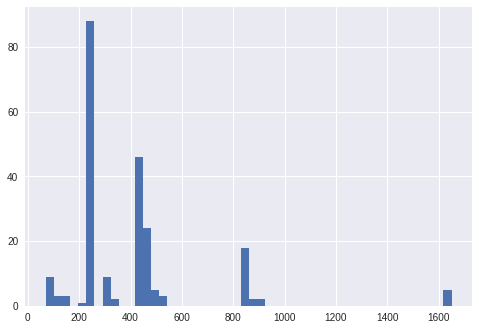

In [77]:
plt.hist(rws, bins=50)

In [75]:
np.save(open('greedy_log.pcl', 'wb'), score_log['expected greedy reward'])
np.save(open('egreedy_log.pcl', 'wb'), score_log['expected e-greedy reward'])

###### Patially used code: Aleksey Grinchuk (AlexGrinch), Mariya Popova (Mariewelt) ... and some hedgehog